In [1]:
import numpy as np
import pandas as pd
import os, sys
import glob
from astropy import units as u
import random
import h5py
import itertools
import multiprocessing as mp
import time
import pickle

from astropy.timeseries import BoxLeastSquares, LombScargle
from scipy.signal import find_peaks, peak_widths
from sklearn.preprocessing import MinMaxScaler

import altair as alt
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from matplotlib import rc
from matplotlib import cm
import matplotlib.colors as colors
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
plt.style.use('classic')
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
rc('figure', facecolor='w')
rc('xtick', labelsize=20)
rc('ytick', labelsize=20)

sys.path.append('/astro/users/jbirky/projects/tess_binaries')
os.environ['TESS_DATA'] = '/data/epyc/projects2/tess'

import tess_binaries as tb

In [2]:
ff = h5py.File(f'{tb.cat_dir}/asassn_tess_inspected.hdf5', mode="r")

df = {}
for key in list(ff):
    if key == 'type':
        df[key] = np.array(ff[key].value, dtype='str')
    else:
        df[key] = ff[key].value
    
ff.close()
sample = pd.DataFrame(data=df)

/epyc/opt/anaconda/lib/python3.6/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


In [3]:
def computePowerSpectra(tic_id, **kwargs):
    
    ps_dir = tb.ps_dir

    data, end_times = tb.readSourceFiles(tic_id)
    ts = data[~np.isnan(data['pdcsap_flux'])]
    
    #Compute lomb-scargle power series
    ls0 = time.time()
    ls =  LombScargle(ts.time.jd, ts['pdcsap_flux'], dy=ts['pdcsap_flux_err'], \
                          normalization='standard')
    ls_freq, ls_power = ls.autopower(minimum_frequency=.001, \
                          maximum_frequency=100, samples_per_peak=10)
    ls_time = time.time() - ls0
    ls_pwr_spec  = np.vstack([np.array(1/ls_freq), np.array(ls_power)])
    print(f'Lomb-Scargle compute time: {ls_time}')
    
    #find best lomb-scargle period
    ls_max_pwr = np.argmax(ls_pwr_spec, axis=1)[1]
    ls_best_period = ls_pwr_spec[0][ls_max_pwr]
    
    #find best BLS period
    bls0 = time.time()
    psamp = 10**3
    rng = [ls_best_period/4, ls_best_period*5]
    model = BoxLeastSquares(ts.time.jd * u.day, ts['pdcsap_flux'], dy=ts['pdcsap_flux_err'])
    periods = np.linspace(rng[0], rng[1], psamp) * u.day
    periodogram = model.power(periods, rng[0]/2)
    bls_time = time.time() - bls0
    
    bls_pwr_spec = np.vstack([np.array(periodogram.period), np.array(periodogram.power)])
    bls_max_pwr = np.argmax(bls_pwr_spec, axis=1)[1]
    bls_best_period = bls_pwr_spec[0][bls_max_pwr]

    ps_output = {'tic_id':tic_id, 'data': data, 'ls_pwr_spec': ls_pwr_spec, 'bls_pwr_spec': bls_pwr_spec, \
                 'ls_best_period': ls_best_period, 'bls_best_period': bls_best_period, \
                 'ls_time': ls_time, 'bls_time': bls_time, 'end_times': end_times}
    
    fname = f'{ps_dir}/{tic_id}_ps.pkl'
    
    print(f'Saving power spectra to {ps_dir}.')
    output = open(fname, 'wb')
    pickle.dump(ps_output, output)
    
    return ps_output

In [58]:
a = computePowerSpectra(sample['tic_id'][0])

/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 815 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 1038 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 280 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 2711 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 780 rows with NaN times
  warnings.warn('Igno

Stacking 12 light curve(s).


Lomb-Scargle compute time: 1.8926117420196533
Saving power spectra to ../results/combined_sector_power_spectra.


In [60]:
print(a['ls_best_period'])
print(a['bls_best_period'])

1.3977335732458522
2.796867681134236


In [97]:
pool = mp.Pool(mp.cpu_count())

t0 = time.time()
result = pool.map(computePowerSpectra, list(sample['tic_id']))
t1 = time.time() - t0

/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 815 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 1038 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 1038 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 2711 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 815 rows with NaN times
  warnings.warn('Ign

Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 280 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 280 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 1038 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 815 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 815 rows with NaN times
  warnings.warn('Ignor

Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 1038 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 2711 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 1038 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 1038 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 280 rows with NaN times
  warnings.warn('Ig

Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 1038 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 1038 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 280 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 1038 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 1038 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).
Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 1038 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 1038 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 280 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 1038 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 973 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 280 rows with NaN times
  warnings.warn('Igno

Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 815 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 815 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 973 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 973 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).
Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 280 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 280 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 973 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 280 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).
Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 2711 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 2.47770619392395
Stacking 1 light curve(s).
Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 1038 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).
Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 973 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).
Saving power spectra to ../results/combined_sector_power_spectra.
Stacking 1 light curve(s).
Stacking 1 light curve(s).
Stacking 1 light curve(s).
Lomb-Scargle compute time: 4.682834148406982


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 973 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).
Lomb-Scargle compute time: 3.7941112518310547
Lomb-Scargle compute time: 4.4987452030181885
Lomb-Scargle compute time: 2.557466983795166
Stacking 1 light curve(s).
Saving power spectra to ../results/combined_sector_power_spectra.
Lomb-Scargle compute time: 1.2062363624572754
Stacking 1 light curve(s).
Lomb-Scargle compute time: 1.4371118545532227
Stacking 1 light curve(s).
Lomb-Scargle compute time: 0.9011087417602539
Lomb-Scargle compute time: 4.261713027954102
Stacking 1 light curve(s).
Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 2711 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 4.634158611297607
Stacking 1 light curve(s).
Lomb-Scargle compute time: 2.1304056644439697
Lomb-Scargle compute time: 0.8541040420532227


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 1038 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 973 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 1.3675804138183594
Lomb-Scargle compute time: 3.7269670963287354
Saving power spectra to ../results/combined_sector_power_spectra.
Saving power spectra to ../results/combined_sector_power_spectra.
Stacking 1 light curve(s).
Stacking 1 light curve(s).
Lomb-Scargle compute time: 1.5566108226776123
Lomb-Scargle compute time: 3.8435184955596924
Stacking 1 light curve(s).
Lomb-Scargle compute time: 1.542881727218628
Saving power spectra to ../results/combined_sector_power_spectra.
Saving power spectra to ../results/combined_sector_power_spectra.
Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 1038 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.
Stacking 1 light curve(s).
Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 973 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.
Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 2711 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).
Stacking 2 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 280 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 746 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.
Stacking 2 light curve(s).
Lomb-Scargle compute time: 2.0522544384002686
Stacking 2 light curve(s).
Stacking 1 light curve(s).
Saving power spectra to ../results/combined_sector_power_spectra.
Stacking 2 light curve(s).
Saving power spectra to ../results/combined_sector_power_spectra.
Lomb-Scargle compute time: 4.7546117305755615
Lomb-Scargle compute time: 4.319477558135986
Saving power spectra to ../results/combined_sector_power_spectra.
Lomb-Scargle compute time: 1.3391749858856201


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 2711 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 2 light curve(s).
Lomb-Scargle compute time: 6.839562892913818


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 973 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.
Saving power spectra to ../results/combined_sector_power_spectra.
Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 2711 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).
Lomb-Scargle compute time: 2.3890082836151123
Lomb-Scargle compute time: 1.1911203861236572
Lomb-Scargle compute time: 2.2140886783599854


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 2711 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 2.962294816970825


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 780 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 2711 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.
Saving power spectra to ../results/combined_sector_power_spectra.
Stacking 1 light curve(s).
Saving power spectra to ../results/combined_sector_power_spectra.
Saving power spectra to ../results/combined_sector_power_spectra.
Lomb-Scargle compute time: 3.32761287689209
Lomb-Scargle compute time: 3.56960129737854
Lomb-Scargle compute time: 3.331289291381836
Stacking 1 light curve(s).
Lomb-Scargle compute time: 0.89247727394104
Lomb-Scargle compute time: 2.5610105991363525


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 1196 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 3.966334819793701
Stacking 1 light curve(s).
Stacking 1 light curve(s).
Stacking 1 light curve(s).
Stacking 1 light curve(s).
Saving power spectra to ../results/combined_sector_power_spectra.
Stacking 1 light curve(s).
Saving power spectra to ../results/combined_sector_power_spectra.
Stacking 2 light curve(s).
Saving power spectra to ../results/combined_sector_power_spectra.
Lomb-Scargle compute time: 2.9161322116851807
Saving power spectra to ../results/combined_sector_power_spectra.
Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 973 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 4.088289976119995


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 1038 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).
Stacking 1 light curve(s).
Stacking 1 light curve(s).
Stacking 2 light curve(s).
Lomb-Scargle compute time: 6.088663816452026
Stacking 2 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 973 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 4.606870889663696
Saving power spectra to ../results/combined_sector_power_spectra.
Stacking 1 light curve(s).
Saving power spectra to ../results/combined_sector_power_spectra.
Saving power spectra to ../results/combined_sector_power_spectra.
Stacking 2 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 746 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.
Stacking 1 light curve(s).
Lomb-Scargle compute time: 1.3971529006958008
Stacking 1 light curve(s).
Lomb-Scargle compute time: 1.714250087738037


Saving power spectra to ../results/combined_sector_power_spectra.
Stacking 1 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 1 light curve(s).
Lomb-Scargle compute time: 1.7170062065124512


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 668 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 280 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 2711 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 2711 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.
Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 280 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 3 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 973 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 2 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 280 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 1196 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 2711 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 3.089247226715088
Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 973 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 1.5733790397644043


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 3200 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 4.51657509803772


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 780 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 1.3761298656463623


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 780 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 1038 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 3.587049961090088


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 973 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).


Lomb-Scargle compute time: 4.372592926025391


Stacking 1 light curve(s).


Lomb-Scargle compute time: 2.313157081604004


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 780 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 3.960498332977295


Stacking 1 light curve(s).


Lomb-Scargle compute time: 2.5722687244415283


Lomb-Scargle compute time: 1.4954652786254883


Lomb-Scargle compute time: 1.5698614120483398


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 780 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 4.005751848220825


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 3.6676058769226074


Stacking 1 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 2 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 973 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 3.368896722793579
Stacking 1 light curve(s).
Saving power spectra to ../results/combined_sector_power_spectra.
Saving power spectra to ../results/combined_sector_power_spectra.
Stacking 1 light curve(s).
Stacking 1 light curve(s).
Stacking 1 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.
Stacking 2 light curve(s).


Stacking 2 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 4 light curve(s).
Lomb-Scargle compute time: 4.7557690143585205


Stacking 2 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 2 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 1038 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 1.8667514324188232
Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 280 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 3.0391688346862793


Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 973 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 6.508427381515503


Stacking 3 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 1 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.
Stacking 3 light curve(s).


Lomb-Scargle compute time: 3.7414655685424805


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 668 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 280 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 973 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 1.1441450119018555


Stacking 3 light curve(s).


Lomb-Scargle compute time: 2.7433459758758545


Lomb-Scargle compute time: 3.396238088607788


Stacking 3 light curve(s).
Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 780 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 2711 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 1.4298906326293945


Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 2711 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 2.6805977821350098


Saving power spectra to ../results/combined_sector_power_spectra.
Stacking 1 light curve(s).
Stacking 1 light curve(s).
Stacking 1 light curve(s).


Stacking 1 light curve(s).


Stacking 1 light curve(s).
Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 3.741943359375


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 1196 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.
Lomb-Scargle compute time: 5.12575888633728
Lomb-Scargle compute time: 4.117800712585449
Lomb-Scargle compute time: 1.8651556968688965
Lomb-Scargle compute time: 1.664496660232544
Saving power spectra to ../results/combined_sector_power_spectra.
Saving power spectra to ../results/combined_sector_power_spectra.
Lomb-Scargle compute time: 5.721465826034546


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 973 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 4.734353065490723


Stacking 1 light curve(s).


Lomb-Scargle compute time: 0.9708781242370605
Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 1.2090096473693848
Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 1038 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 1.69169282913208
Stacking 3 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 280 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 3.8731701374053955


Stacking 2 light curve(s).


Lomb-Scargle compute time: 2.405035972595215


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.
Stacking 1 light curve(s).
Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 2.3866539001464844


Stacking 1 light curve(s).
Lomb-Scargle compute time: 5.499334335327148


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 3200 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 2.378307342529297


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 2 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 3.137265205383301


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 280 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 2 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 1038 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 2 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 2711 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 1.243720531463623


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 280 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 5.534688711166382


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 1.4465548992156982


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 780 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 0.9846303462982178
Stacking 3 light curve(s).
Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 2 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 1038 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 2711 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 3.6313118934631348
Stacking 1 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 3.0060107707977295


Stacking 1 light curve(s).


Stacking 2 light curve(s).


Stacking 4 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 780 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 280 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).
Saving power spectra to ../results/combined_sector_power_spectra.
Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 1 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 1 light curve(s).


Lomb-Scargle compute time: 0.8972973823547363


Stacking 1 light curve(s).


Stacking 1 light curve(s).
Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 973 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).


Lomb-Scargle compute time: 2.150270938873291


Lomb-Scargle compute time: 0.859438419342041


Saving power spectra to ../results/combined_sector_power_spectra.
Lomb-Scargle compute time: 1.0912742614746094


Stacking 2 light curve(s).


Lomb-Scargle compute time: 2.060603141784668


Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 1196 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 3 light curve(s).
Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 1 light curve(s).


Stacking 1 light curve(s).


Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 1196 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 1 light curve(s).
Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 3.0731232166290283


Lomb-Scargle compute time: 3.2697596549987793


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 280 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).


Stacking 2 light curve(s).


Stacking 3 light curve(s).


Stacking 1 light curve(s).


Stacking 3 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 2.8162503242492676


Lomb-Scargle compute time: 4.554929494857788


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 850 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 973 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 3.3533408641815186


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 1 light curve(s).


Stacking 2 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 280 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.
Lomb-Scargle compute time: 2.7737159729003906


Lomb-Scargle compute time: 2.4731035232543945


Lomb-Scargle compute time: 1.3111953735351562


Lomb-Scargle compute time: 1.6385655403137207


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 1.078300952911377


Stacking 2 light curve(s).


Lomb-Scargle compute time: 2.726593255996704


Stacking 1 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 2.928180456161499


Stacking 1 light curve(s).


Stacking 1 light curve(s).


Stacking 1 light curve(s).
Lomb-Scargle compute time: 3.215031385421753


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 2.8632333278656006


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 1038 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 973 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 5.503534317016602


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 2711 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.
Stacking 1 light curve(s).


Lomb-Scargle compute time: 11.927343606948853


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 280 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 1038 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 2 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 2711 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 4.691138029098511


Stacking 3 light curve(s).


Lomb-Scargle compute time: 2.512619733810425


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 3.876539707183838


Lomb-Scargle compute time: 1.7856576442718506
Lomb-Scargle compute time: 2.6381356716156006


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 2711 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 2.774402618408203


Lomb-Scargle compute time: 2.7848398685455322


Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 3200 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 9.34916639328003
Stacking 1 light curve(s).


Lomb-Scargle compute time: 1.8506062030792236


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 780 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 3 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 3200 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.
Stacking 1 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 1 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.
Stacking 1 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 1.257979393005371
Lomb-Scargle compute time: 6.402454137802124


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 973 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 1 light curve(s).


Lomb-Scargle compute time: 0.7732741832733154


Saving power spectra to ../results/combined_sector_power_spectra.
Lomb-Scargle compute time: 5.98328423500061
Lomb-Scargle compute time: 12.764668464660645


Stacking 1 light curve(s).
Stacking 1 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 1.1242003440856934


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 2.3110291957855225


Stacking 1 light curve(s).
Lomb-Scargle compute time: 4.107882976531982


Stacking 1 light curve(s).


Stacking 1 light curve(s).


Lomb-Scargle compute time: 1.5450372695922852


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 703 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 2.874138355255127


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 280 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 2711 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 2 light curve(s).


Lomb-Scargle compute time: 1.3145115375518799


Stacking 1 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 780 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 7.185872554779053


Saving power spectra to ../results/combined_sector_power_spectra.
Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 2.440966844558716


Lomb-Scargle compute time: 3.3781392574310303


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 1.9274895191192627
Lomb-Scargle compute time: 4.264297008514404


Stacking 1 light curve(s).


Lomb-Scargle compute time: 1.4505934715270996
Lomb-Scargle compute time: 1.5814919471740723


Stacking 1 light curve(s).


Lomb-Scargle compute time: 1.456575870513916


Stacking 1 light curve(s).
Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 11.738876819610596


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 1.1252496242523193


Stacking 1 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 2 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 2711 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 973 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 850 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).


Lomb-Scargle compute time: 1.1491093635559082


Lomb-Scargle compute time: 7.622114181518555


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 2711 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 2711 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 850 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 3200 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 5.9512763023376465


Lomb-Scargle compute time: 3.019913673400879


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 7.536869525909424
Lomb-Scargle compute time: 1.897658348083496
Stacking 1 light curve(s).


Lomb-Scargle compute time: 1.0482587814331055


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 1 light curve(s).


Lomb-Scargle compute time: 8.65223240852356
Lomb-Scargle compute time: 2.433499336242676


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 2711 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 3.316542625427246


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 1038 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.
Lomb-Scargle compute time: 1.9224746227264404


Stacking 1 light curve(s).


Stacking 1 light curve(s).


Stacking 1 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 780 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 1.7115592956542969


Stacking 1 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.
Saving power spectra to ../results/combined_sector_power_spectra.
Stacking 1 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 2711 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 2711 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.
Lomb-Scargle compute time: 4.744859218597412
Stacking 1 light curve(s).
Saving power spectra to ../results/combined_sector_power_spectra.
Stacking 1 light curve(s).
Stacking 1 light curve(s).
Stacking 1 light curve(s).
Saving power spectra to ../results/combined_sector_power_spectra.
Lomb-Scargle compute time: 3.1091420650482178
Lomb-Scargle compute time: 1.6704087257385254
Stacking 1 light curve(s).
Saving power spectra to ../results/combined_sector_power_spectra.
Lomb-Scargle compute time: 4.267555236816406
Lomb-Scargle compute time: 1.1796042919158936
Lomb-Scargle compute time: 2.5473527908325195
Lomb-Scargle compute time: 1.6162447929382324
Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 973 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 3.306770086288452


Lomb-Scargle compute time: 3.590034246444702


Lomb-Scargle compute time: 2.5677430629730225


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 2711 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 2.205829381942749


Lomb-Scargle compute time: 1.0478994846343994


Lomb-Scargle compute time: 3.7371225357055664


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 2711 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 2.344403028488159


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 780 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 0.9323868751525879


Lomb-Scargle compute time: 1.378509521484375


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 746 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 973 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 973 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.
Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 778 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 2 light curve(s).
Saving power spectra to ../results/combined_sector_power_spectra.
Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 280 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 2.090273857116699


Saving power spectra to ../results/combined_sector_power_spectra.
Lomb-Scargle compute time: 4.254526853561401


Lomb-Scargle compute time: 2.1070497035980225


Stacking 1 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 3.614231586456299


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 703 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 973 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.
Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 0.6919605731964111


Lomb-Scargle compute time: 0.5017807483673096


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 703 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 973 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 780 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.
Stacking 1 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 780 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 2.8739733695983887


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 973 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 3200 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 973 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 5.495082855224609


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 973 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 1196 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 2711 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 0.6961522102355957
Lomb-Scargle compute time: 2.2255842685699463
Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 850 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.
Saving power spectra to ../results/combined_sector_power_spectra.
Saving power spectra to ../results/combined_sector_power_spectra.
Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 973 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 973 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 0.6403319835662842


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 973 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 280 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 0.902193546295166
Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 1196 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 973 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 2 light curve(s).


Stacking 8 light curve(s).
Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 780 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 973 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 1.9366264343261719


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 973 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 778 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 973 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 3.4392201900482178


Lomb-Scargle compute time: 0.807645320892334


Stacking 1 light curve(s).


Lomb-Scargle compute time: 0.8790273666381836


Stacking 1 light curve(s).


Stacking 1 light curve(s).
Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 668 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 973 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 1038 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 850 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 780 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).


Lomb-Scargle compute time: 0.9044651985168457


Stacking 1 light curve(s).


Stacking 2 light curve(s).
Lomb-Scargle compute time: 0.7655701637268066


Lomb-Scargle compute time: 9.153364181518555


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 1196 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 0.6824390888214111


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 1196 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 973 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 668 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 973 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 3 light curve(s).
Saving power spectra to ../results/combined_sector_power_spectra.
Lomb-Scargle compute time: 0.67856764793396
Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 703 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 973 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 1.7357559204101562
Lomb-Scargle compute time: 1.9568262100219727
Lomb-Scargle compute time: 1.3851468563079834


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 973 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 1.6236398220062256
Saving power spectra to ../results/combined_sector_power_spectra.
Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 973 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).
Stacking 1 light curve(s).
Saving power spectra to ../results/combined_sector_power_spectra.
Saving power spectra to ../results/combined_sector_power_spectra.
Stacking 2 light curve(s).
Stacking 2 light curve(s).
Stacking 2 light curve(s).
Lomb-Scargle compute time: 0.986314058303833


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 780 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).
Saving power spectra to ../results/combined_sector_power_spectra.
Lomb-Scargle compute time: 1.560378074645996
Lomb-Scargle compute time: 2.0392773151397705


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 973 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 0.6082086563110352


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 1196 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 780 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 780 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.
Saving power spectra to ../results/combined_sector_power_spectra.
Stacking 3 light curve(s).
Lomb-Scargle compute time: 0.8595767021179199
Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 778 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 973 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 2711 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 3200 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).


Lomb-Scargle compute time: 1.1251778602600098


Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 703 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 1.7032740116119385


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 746 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 2711 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.
Stacking 5 light curve(s).
Stacking 1 light curve(s).
Stacking 1 light curve(s).
Saving power spectra to ../results/combined_sector_power_spectra.
Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 973 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 973 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 3 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 1196 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 1 light curve(s).
Lomb-Scargle compute time: 1.3307580947875977


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 973 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 973 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 1.6835815906524658


Lomb-Scargle compute time: 1.145090103149414


Lomb-Scargle compute time: 0.7180061340332031
Stacking 2 light curve(s).


Lomb-Scargle compute time: 1.362513780593872


Lomb-Scargle compute time: 6.437258243560791


Lomb-Scargle compute time: 2.4321558475494385
Stacking 1 light curve(s).
Lomb-Scargle compute time: 2.1494076251983643


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 973 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.
Stacking 1 light curve(s).
Stacking 3 light curve(s).
Saving power spectra to ../results/combined_sector_power_spectra.
Lomb-Scargle compute time: 0.929990291595459
Stacking 2 light curve(s).
Lomb-Scargle compute time: 1.8328642845153809
Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 780 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 780 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.
Lomb-Scargle compute time: 0.8188004493713379
Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 3200 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).
Saving power spectra to ../results/combined_sector_power_spectra.
Stacking 2 light curve(s).
Saving power spectra to ../results/combined_sector_power_spectra.
Stacking 2 light curve(s).
Lomb-Scargle compute time: 1.3426704406738281
Stacking 2 light curve(s).
Saving power spectra to ../results/combined_sector_power_spectra.
Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 780 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 3200 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).
Stacking 1 light curve(s).
Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 778 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 778 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 1196 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 1038 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).
Lomb-Scargle compute time: 1.7476544380187988


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 973 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 0.7037718296051025


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 668 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 703 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 1 light curve(s).


Stacking 1 light curve(s).


Stacking 3 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 280 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 1.946640968322754


Stacking 1 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 1.165489912033081


Lomb-Scargle compute time: 1.665057897567749


Lomb-Scargle compute time: 1.0828924179077148


Stacking 1 light curve(s).


Stacking 1 light curve(s).


Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 780 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 973 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 668 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 973 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 746 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 2 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 780 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 1 light curve(s).
Lomb-Scargle compute time: 1.193349838256836


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 973 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 1.090125322341919


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 3200 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 3200 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.
Lomb-Scargle compute time: 1.786787748336792
Lomb-Scargle compute time: 1.2040815353393555
Stacking 8 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 973 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 1.6814887523651123
Lomb-Scargle compute time: 2.205777168273926
Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 1196 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 2.061903715133667


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 780 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).


Lomb-Scargle compute time: 1.717015027999878


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 2.0844526290893555


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 280 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 1.7961299419403076


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 973 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 850 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 1.590212106704712


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 3200 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 973 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 2 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 703 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).
Stacking 1 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 2 light curve(s).


Stacking 2 light curve(s).


Stacking 1 light curve(s).


Stacking 2 light curve(s).


Stacking 1 light curve(s).


Stacking 1 light curve(s).


Stacking 1 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 1.7859559059143066
Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 780 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 0.4644463062286377


Lomb-Scargle compute time: 3.2915844917297363


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 1196 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 2 light curve(s).


Stacking 1 light curve(s).


Stacking 1 light curve(s).


Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 746 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 1.810777187347412


Lomb-Scargle compute time: 0.8865091800689697


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 780 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 746 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 1.8220646381378174


Lomb-Scargle compute time: 1.8571672439575195


Stacking 2 light curve(s).
Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 1 light curve(s).
Lomb-Scargle compute time: 1.4219045639038086


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 2 light curve(s).


Lomb-Scargle compute time: 0.9680464267730713


Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 973 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 850 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 973 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 850 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 11 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 1196 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 2.069199800491333


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 778 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 973 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).


Stacking 2 light curve(s).
Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.
Stacking 1 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 3.8732383251190186


Lomb-Scargle compute time: 1.8916194438934326
Stacking 1 light curve(s).


Lomb-Scargle compute time: 1.2676122188568115


Stacking 3 light curve(s).


Lomb-Scargle compute time: 1.8745243549346924


Lomb-Scargle compute time: 1.8518376350402832


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 973 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 2.0198915004730225


Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 850 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 1.72056245803833


Lomb-Scargle compute time: 1.0603821277618408


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 850 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 2.0617289543151855


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 280 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 778 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 668 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 1.6273348331451416


Saving power spectra to ../results/combined_sector_power_spectra.
Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 1.3511714935302734


Lomb-Scargle compute time: 1.063169240951538


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 703 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 780 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).
Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.
Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 973 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 850 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).


Stacking 1 light curve(s).


Lomb-Scargle compute time: 1.4663960933685303


Lomb-Scargle compute time: 4.716585397720337


Stacking 1 light curve(s).


Lomb-Scargle compute time: 1.7732319831848145


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 780 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.
Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 973 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 2 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 0.9056897163391113


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 780 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 2 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 668 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).


Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 668 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 1.1100633144378662
Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 973 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.
Lomb-Scargle compute time: 1.338019609451294


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 1038 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 2.4497735500335693


Lomb-Scargle compute time: 1.7075963020324707


Stacking 1 light curve(s).


Stacking 1 light curve(s).


Stacking 1 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 1.7909057140350342


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 973 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 778 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).


Stacking 3 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 973 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 1 light curve(s).


Lomb-Scargle compute time: 0.7406203746795654


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 668 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 5.676200866699219


Lomb-Scargle compute time: 1.859635353088379


Stacking 1 light curve(s).


Lomb-Scargle compute time: 1.9340434074401855


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 780 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 2.307736873626709


Lomb-Scargle compute time: 2.431528091430664


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 973 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 2.3993892669677734


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 780 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 1.4850327968597412


Lomb-Scargle compute time: 0.671276330947876


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 3200 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 2 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 1.726346731185913


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 778 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 2.579916477203369


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 3200 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 780 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 703 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 746 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 703 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 780 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 703 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 780 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 703 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 2711 rows with NaN times
  warnings.warn('Ignor

Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 8.388931512832642


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 1 light curve(s).


Stacking 1 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 746 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 780 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 780 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 703 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 780 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 12 light curve(s).


Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 668 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).


Stacking 1 light curve(s).


Stacking 2 light curve(s).
Lomb-Scargle compute time: 1.07291841506958


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 3.712106943130493


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 1196 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).
Lomb-Scargle compute time: 1.8296821117401123
Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 3 light curve(s).


Stacking 1 light curve(s).


Stacking 8 light curve(s).


Stacking 5 light curve(s).


Lomb-Scargle compute time: 4.262407064437866
Stacking 5 light curve(s).


Lomb-Scargle compute time: 1.369093418121338
Stacking 1 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.
Lomb-Scargle compute time: 1.1963424682617188


Lomb-Scargle compute time: 3.056870698928833


Lomb-Scargle compute time: 2.917079448699951


Lomb-Scargle compute time: 1.5853819847106934
Stacking 1 light curve(s).


Stacking 1 light curve(s).
Stacking 1 light curve(s).


Lomb-Scargle compute time: 2.737652540206909
Lomb-Scargle compute time: 3.0048673152923584


Lomb-Scargle compute time: 3.4252822399139404


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 780 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 3.8892037868499756
Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 1 light curve(s).


Stacking 1 light curve(s).


Lomb-Scargle compute time: 0.7554881572723389


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 780 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 1.890622854232788


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 280 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 0.7903158664703369


Lomb-Scargle compute time: 0.9259953498840332
Saving power spectra to ../results/combined_sector_power_spectra.
Stacking 1 light curve(s).


Stacking 8 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 2.418856620788574


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 780 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.
Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 1.5898475646972656


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 746 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 778 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 850 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 3200 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 3.686530351638794


Stacking 1 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 780 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 1196 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 1196 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).
Lomb-Scargle compute time: 0.9391305446624756


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 746 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 2.8572475910186768


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 778 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 2.9384140968322754


Stacking 5 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 746 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 1.672478199005127
Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 668 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 2.5749893188476562


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 973 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).
Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 746 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 1196 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 1.392845869064331
Stacking 1 light curve(s).
Saving power spectra to ../results/combined_sector_power_spectra.
Saving power spectra to ../results/combined_sector_power_spectra.
Saving power spectra to ../results/combined_sector_power_spectra.
Lomb-Scargle compute time: 1.387073278427124
Lomb-Scargle compute time: 1.7894020080566406
Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 1196 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 1.143972635269165


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 780 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 780 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 2711 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 1.1364693641662598


Stacking 2 light curve(s).
Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 780 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 2.8201587200164795


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 780 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.
Lomb-Scargle compute time: 1.0163702964782715


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 780 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 3.3123281002044678


Lomb-Scargle compute time: 1.5089566707611084


Stacking 1 light curve(s).
Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 1 light curve(s).


Lomb-Scargle compute time: 1.454824447631836


Lomb-Scargle compute time: 1.0178413391113281


Stacking 2 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 780 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 7.4903764724731445


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 778 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 2.951219320297241


Lomb-Scargle compute time: 0.842219352722168
Stacking 1 light curve(s).
Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 1196 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 2711 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 850 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 2 light curve(s).
Stacking 1 light curve(s).
Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 0.7339529991149902


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 3200 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 850 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 1196 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 0.8103852272033691
Lomb-Scargle compute time: 2.620718479156494
Lomb-Scargle compute time: 1.180086612701416


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 1196 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).
Lomb-Scargle compute time: 2.2004668712615967
Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 703 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.
Stacking 3 light curve(s).
Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 780 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 780 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 9 light curve(s).
Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 1196 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).
Stacking 1 light curve(s).
Stacking 1 light curve(s).
Lomb-Scargle compute time: 2.4915506839752197


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 3200 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 2.0087244510650635


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 1196 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.
Saving power spectra to ../results/combined_sector_power_spectra.
Lomb-Scargle compute time: 1.0712242126464844
Lomb-Scargle compute time: 1.7372915744781494
Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 1196 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 1196 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 703 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 1196 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 5 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.
Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 1196 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).


Stacking 1 light curve(s).


Stacking 1 light curve(s).


Lomb-Scargle compute time: 2.5860743522644043
Stacking 1 light curve(s).
Stacking 2 light curve(s).


Lomb-Scargle compute time: 1.7317509651184082
Lomb-Scargle compute time: 0.8961195945739746
Stacking 1 light curve(s).
Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 668 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.
Lomb-Scargle compute time: 4.070647239685059


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 1196 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 7.819230794906616
Stacking 2 light curve(s).
Saving power spectra to ../results/combined_sector_power_spectra.
Saving power spectra to ../results/combined_sector_power_spectra.
Saving power spectra to ../results/combined_sector_power_spectra.
Lomb-Scargle compute time: 2.716618776321411
Lomb-Scargle compute time: 1.116316318511963
Lomb-Scargle compute time: 2.0754857063293457


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 746 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.
Lomb-Scargle compute time: 2.612441062927246


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 3200 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).
Saving power spectra to ../results/combined_sector_power_spectra.
Stacking 1 light curve(s).
Saving power spectra to ../results/combined_sector_power_spectra.
Stacking 2 light curve(s).
Lomb-Scargle compute time: 1.5918653011322021


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 746 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 2 light curve(s).
Lomb-Scargle compute time: 2.110978364944458
Saving power spectra to ../results/combined_sector_power_spectra.
Saving power spectra to ../results/combined_sector_power_spectra.
Lomb-Scargle compute time: 1.70512056350708
Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 1 light curve(s).


Stacking 2 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.
Lomb-Scargle compute time: 1.7887470722198486


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 668 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 3200 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 746 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 3200 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).


Lomb-Scargle compute time: 1.4756817817687988
Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 703 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 3200 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 3200 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 3200 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 3.0511839389801025


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 3200 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 1196 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 703 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 0.9617807865142822


Lomb-Scargle compute time: 2.5127692222595215


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 778 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).


Lomb-Scargle compute time: 1.7134718894958496


Stacking 1 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 1.1585700511932373


Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 3200 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 2.114121437072754


Saving power spectra to ../results/combined_sector_power_spectra.
Lomb-Scargle compute time: 1.2714753150939941


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 1 light curve(s).
Lomb-Scargle compute time: 12.901089906692505


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 3200 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).


Lomb-Scargle compute time: 0.9893255233764648


Lomb-Scargle compute time: 0.906327486038208


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 973 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 1 light curve(s).


Stacking 1 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.
Stacking 1 light curve(s).
Stacking 1 light curve(s).
Stacking 9 light curve(s).


Stacking 1 light curve(s).


Lomb-Scargle compute time: 1.2361159324645996


Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 850 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 850 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 3200 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 1.5924806594848633


Stacking 1 light curve(s).


Lomb-Scargle compute time: 2.330721616744995


Lomb-Scargle compute time: 1.5119917392730713


Stacking 1 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 0.902921199798584


Lomb-Scargle compute time: 1.1501796245574951


Lomb-Scargle compute time: 0.99137282371521


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 778 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 1.6110200881958008


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 1 light curve(s).


Stacking 1 light curve(s).


Lomb-Scargle compute time: 1.963975429534912


Stacking 1 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 1 light curve(s).


Stacking 1 light curve(s).


Lomb-Scargle compute time: 1.1116762161254883


Lomb-Scargle compute time: 2.55576753616333


Stacking 1 light curve(s).


Stacking 1 light curve(s).


Lomb-Scargle compute time: 1.3266212940216064


Stacking 1 light curve(s).
Lomb-Scargle compute time: 2.1375463008880615


Lomb-Scargle compute time: 2.1037139892578125


Saving power spectra to ../results/combined_sector_power_spectra.
Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 1 light curve(s).


Lomb-Scargle compute time: 1.0107269287109375


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 3200 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 1 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 0.9701611995697021


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 1.137150526046753


Stacking 1 light curve(s).
Lomb-Scargle compute time: 3.907780408859253


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 668 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 1.255277156829834


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 1.5595378875732422
Stacking 1 light curve(s).
Saving power spectra to ../results/combined_sector_power_spectra.
Lomb-Scargle compute time: 1.7697722911834717


Lomb-Scargle compute time: 1.5842435359954834


Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 850 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 850 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 850 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 0.8952314853668213
Lomb-Scargle compute time: 2.2836854457855225


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 668 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 0.5705599784851074
Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 703 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 1.7345874309539795


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 0.7933223247528076


Stacking 1 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.
Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 0.9185190200805664
Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 11 light curve(s).


Lomb-Scargle compute time: 2.9341793060302734


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 3200 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 778 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).


Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 850 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 668 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 3.2152116298675537


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 850 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 1 light curve(s).


Stacking 5 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 850 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 668 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 668 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.
Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 780 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 0.8971188068389893


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 703 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 3.8144798278808594


Lomb-Scargle compute time: 2.239293336868286


Lomb-Scargle compute time: 1.9728925228118896


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 850 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 2.316762685775757


Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 1196 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 280 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 780 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 780 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 850 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 850 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 3200 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 3.2041141986846924


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 850 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 850 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 2.3788487911224365


Stacking 9 light curve(s).


Lomb-Scargle compute time: 7.647916316986084


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 850 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).


Stacking 2 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 703 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 850 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 2.374502182006836


Lomb-Scargle compute time: 1.9139604568481445


Stacking 1 light curve(s).


Stacking 4 light curve(s).


Lomb-Scargle compute time: 8.814521312713623


Lomb-Scargle compute time: 5.351934909820557


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 703 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 1 light curve(s).


Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 3200 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 2.392176866531372


Stacking 2 light curve(s).


Lomb-Scargle compute time: 1.6667101383209229


Stacking 1 light curve(s).


Stacking 11 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 850 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).
Stacking 12 light curve(s).


Stacking 8 light curve(s).
Lomb-Scargle compute time: 1.2959916591644287


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 1 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 8.793733835220337


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 850 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).


Stacking 1 light curve(s).


Stacking 4 light curve(s).


Lomb-Scargle compute time: 1.5418775081634521
Stacking 1 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 1.5097475051879883


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 2 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 850 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 0.9468495845794678


Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 850 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 0.9281558990478516


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 780 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.
Stacking 2 light curve(s).


Stacking 1 light curve(s).


Lomb-Scargle compute time: 8.108050346374512


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 1.2179322242736816


Stacking 3 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 850 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 778 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 1196 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).


Stacking 1 light curve(s).


Lomb-Scargle compute time: 1.555811882019043


Lomb-Scargle compute time: 1.0945343971252441


Lomb-Scargle compute time: 2.445010185241699


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 1.3471081256866455


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 1196 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 2.163767099380493


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 746 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 1 light curve(s).


Stacking 12 light curve(s).
Lomb-Scargle compute time: 1.4648044109344482


Saving power spectra to ../results/combined_sector_power_spectra.
Stacking 1 light curve(s).


Stacking 1 light curve(s).


Stacking 1 light curve(s).


Lomb-Scargle compute time: 0.8740866184234619


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 2 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 2711 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 1 light curve(s).


Lomb-Scargle compute time: 1.2131688594818115
Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 703 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 703 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 0.7739877700805664


Lomb-Scargle compute time: 1.3865315914154053


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 850 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 1 light curve(s).
Stacking 1 light curve(s).
Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 850 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 850 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 778 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 703 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 746 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 1.1192715167999268


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 2 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 850 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 0.6530277729034424


Lomb-Scargle compute time: 1.7746942043304443


Lomb-Scargle compute time: 1.3131709098815918


Lomb-Scargle compute time: 0.7722148895263672


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 1.8875453472137451


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 778 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 746 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 850 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 850 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 1 light curve(s).


Lomb-Scargle compute time: 1.3547883033752441


Stacking 2 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 1.7540767192840576


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 850 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 703 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 703 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 850 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 703 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 703 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 1 light curve(s).


Lomb-Scargle compute time: 0.6000213623046875


Stacking 1 light curve(s).


Stacking 1 light curve(s).


Lomb-Scargle compute time: 1.6086440086364746
Lomb-Scargle compute time: 1.92606782913208


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 778 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 3200 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 0.7465071678161621


Lomb-Scargle compute time: 0.610917329788208


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 1 light curve(s).


Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 668 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 3 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 850 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 1.3861429691314697


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 850 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 746 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 3 light curve(s).


Stacking 3 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 778 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 2.9818379878997803


Stacking 1 light curve(s).


Lomb-Scargle compute time: 1.302579402923584
Lomb-Scargle compute time: 1.5211873054504395


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 668 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 850 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 850 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 703 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 703 rows with NaN times
  warnings.warn('Ignori

Lomb-Scargle compute time: 2.8242380619049072


Lomb-Scargle compute time: 2.3433146476745605


Stacking 1 light curve(s).


Lomb-Scargle compute time: 0.8493518829345703


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 703 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).
Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 778 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 703 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 703 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 850 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 703 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 2.2503557205200195


Stacking 1 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 0.920006513595581


Stacking 2 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 3200 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 668 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 2 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 703 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 1.699021339416504


Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 703 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 778 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 703 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 2 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 778 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 0.7958953380584717


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 668 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).


Lomb-Scargle compute time: 3.0503041744232178


Lomb-Scargle compute time: 1.9037740230560303
Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 3200 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 11 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 850 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 703 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).


Stacking 1 light curve(s).


Stacking 1 light curve(s).
Stacking 2 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 850 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 703 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 668 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 703 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 2.5541558265686035


Stacking 4 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 0.7338161468505859


Lomb-Scargle compute time: 1.1145176887512207


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 703 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 1.9585602283477783


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 703 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 703 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 746 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 746 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 703 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 746 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 1 light curve(s).


Lomb-Scargle compute time: 2.1460790634155273
Lomb-Scargle compute time: 2.37644362449646


Lomb-Scargle compute time: 2.1171672344207764


Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 703 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 668 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 6 light curve(s).
Saving power spectra to ../results/combined_sector_power_spectra.
Stacking 1 light curve(s).


Lomb-Scargle compute time: 1.061976671218872


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 1 light curve(s).


Lomb-Scargle compute time: 0.7438066005706787


Stacking 1 light curve(s).


Lomb-Scargle compute time: 1.034229040145874


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 703 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 4.086090087890625


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 703 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 746 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 703 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 703 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 1.8982980251312256


Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 850 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 1.1014246940612793


Stacking 2 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 668 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 4.895169019699097


Lomb-Scargle compute time: 1.397590160369873


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 778 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 2 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 1 light curve(s).
Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 1.3787147998809814


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 4.832937479019165


Lomb-Scargle compute time: 12.93759536743164


Stacking 1 light curve(s).


Stacking 3 light curve(s).


Lomb-Scargle compute time: 1.4333415031433105


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 0.8321442604064941


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 703 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 778 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 14.114293336868286


Lomb-Scargle compute time: 15.232178449630737


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 1038 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 2 light curve(s).


Stacking 5 light curve(s).


Stacking 1 light curve(s).
Lomb-Scargle compute time: 2.397251844406128
Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 778 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 703 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 778 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).


Lomb-Scargle compute time: 1.5255799293518066


Stacking 2 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 703 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 6.450304985046387


Lomb-Scargle compute time: 13.24511456489563


Stacking 1 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 14.88629150390625


Stacking 1 light curve(s).
Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 703 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 778 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 703 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 0.778724193572998


Lomb-Scargle compute time: 0.7848591804504395
Stacking 4 light curve(s).


Stacking 1 light curve(s).


Lomb-Scargle compute time: 1.0908527374267578


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 746 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 778 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 703 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 2.153974771499634


Lomb-Scargle compute time: 1.4418971538543701


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 703 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 703 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 1.3230791091918945


Lomb-Scargle compute time: 2.092118978500366


Saving power spectra to ../results/combined_sector_power_spectra.
Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 778 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.
Saving power spectra to ../results/combined_sector_power_spectra.
Lomb-Scargle compute time: 0.8140895366668701


Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 778 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 2.556621789932251


Saving power spectra to ../results/combined_sector_power_spectra.
Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 778 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 2 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 3200 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 668 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 703 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 0.9918689727783203
Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 746 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 703 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 3.0030548572540283


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 778 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 3.01973295211792


Lomb-Scargle compute time: 0.9540119171142578


Stacking 2 light curve(s).


Stacking 1 light curve(s).
Lomb-Scargle compute time: 1.8547351360321045


Lomb-Scargle compute time: 3.561196804046631


Lomb-Scargle compute time: 0.7173967361450195


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 703 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 703 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 3 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 778 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.
Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 0.8819284439086914


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 778 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 778 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.
Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 746 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 2 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 778 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).


Stacking 12 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 668 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 1.9913134574890137


Stacking 1 light curve(s).


Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 668 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 778 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 2 light curve(s).
Stacking 2 light curve(s).


Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 778 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 1.9192767143249512


Stacking 1 light curve(s).


Lomb-Scargle compute time: 1.123903751373291


Stacking 2 light curve(s).


Lomb-Scargle compute time: 1.6400845050811768


Lomb-Scargle compute time: 0.8867785930633545


Stacking 4 light curve(s).


Lomb-Scargle compute time: 1.22627854347229


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 746 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 0.9366123676300049


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 778 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 3 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.
Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 1.6549341678619385


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 703 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 746 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 778 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 1 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 778 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 778 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 668 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 1 light curve(s).


Lomb-Scargle compute time: 0.9207944869995117


Lomb-Scargle compute time: 1.0085017681121826


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 778 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 2 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 778 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 668 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 4 light curve(s).


Lomb-Scargle compute time: 1.0194718837738037


Stacking 5 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 11.095438003540039


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 746 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 778 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 2 light curve(s).


Stacking 2 light curve(s).


Stacking 1 light curve(s).
Lomb-Scargle compute time: 1.122570276260376


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 778 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 778 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 778 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).


Stacking 1 light curve(s).


Lomb-Scargle compute time: 2.6088387966156006


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 1 light curve(s).


Lomb-Scargle compute time: 0.7102358341217041


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 10 light curve(s).


Lomb-Scargle compute time: 0.6951100826263428


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 703 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 12 light curve(s).
Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 703 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 778 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 746 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 2 light curve(s).


Lomb-Scargle compute time: 0.9108703136444092


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 703 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 778 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 2 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 668 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 2 light curve(s).
Lomb-Scargle compute time: 2.0076828002929688


Lomb-Scargle compute time: 4.593867301940918


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 778 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 778 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 778 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 3.1029000282287598


Lomb-Scargle compute time: 2.1276774406433105


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 4.04483962059021


Lomb-Scargle compute time: 1.8319814205169678


Lomb-Scargle compute time: 3.794909715652466


Stacking 5 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 746 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 778 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).


Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 778 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 13.84644341468811


Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 746 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 668 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.
Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 778 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 778 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 2 light curve(s).


Stacking 4 light curve(s).


Stacking 1 light curve(s).


Stacking 1 light curve(s).


Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 703 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 746 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).


Lomb-Scargle compute time: 2.160280227661133
Stacking 1 light curve(s).
Lomb-Scargle compute time: 1.4073355197906494


Lomb-Scargle compute time: 1.6305644512176514


Stacking 1 light curve(s).


Lomb-Scargle compute time: 2.135619640350342


Lomb-Scargle compute time: 0.7485427856445312


Stacking 2 light curve(s).
Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 1.4555249214172363


Stacking 1 light curve(s).
Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 1.6405346393585205


Lomb-Scargle compute time: 1.6095855236053467


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 668 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 5 light curve(s).


Lomb-Scargle compute time: 4.39451789855957


Lomb-Scargle compute time: 1.5305933952331543


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 3.508601665496826


Stacking 1 light curve(s).


Lomb-Scargle compute time: 1.9999561309814453


Lomb-Scargle compute time: 1.8850147724151611


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 778 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.
Lomb-Scargle compute time: 2.841503143310547
Lomb-Scargle compute time: 15.505531311035156


Lomb-Scargle compute time: 0.7682831287384033


Stacking 1 light curve(s).


Stacking 1 light curve(s).


Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 778 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 1.9539074897766113


Stacking 1 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 2.7362053394317627


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 2.702312707901001


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 746 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 0.6938581466674805


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 3 light curve(s).
Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 2 light curve(s).


Stacking 1 light curve(s).


Lomb-Scargle compute time: 0.7223858833312988


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 778 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 0.7927188873291016


Stacking 1 light curve(s).


Stacking 1 light curve(s).


Lomb-Scargle compute time: 0.7114062309265137


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 668 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 1 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 778 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 1.1504712104797363


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 746 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 1.636963129043579


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 746 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 0.8066213130950928


Lomb-Scargle compute time: 0.7416641712188721
Stacking 12 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 5 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 1.205986499786377


Stacking 2 light curve(s).


Lomb-Scargle compute time: 1.3550777435302734


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 746 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 1 light curve(s).


Stacking 1 light curve(s).


Stacking 4 light curve(s).


Stacking 1 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 1 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 2.486060619354248


Stacking 4 light curve(s).
Lomb-Scargle compute time: 1.1383886337280273


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 778 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 668 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 1.2315118312835693


Lomb-Scargle compute time: 1.3592469692230225


Lomb-Scargle compute time: 1.5260450839996338


Lomb-Scargle compute time: 10.96384048461914


Stacking 1 light curve(s).


Stacking 1 light curve(s).


Lomb-Scargle compute time: 1.8497076034545898


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 2.4994747638702393


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 778 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 0.5556433200836182


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 778 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 1.0660240650177002


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 2 light curve(s).
Lomb-Scargle compute time: 2.125704050064087


Stacking 4 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 668 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 746 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 746 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 1.6966893672943115


Lomb-Scargle compute time: 0.8863143920898438


Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 746 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 746 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).


Lomb-Scargle compute time: 4.609922170639038


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 703 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 5 light curve(s).


Stacking 2 light curve(s).


Lomb-Scargle compute time: 1.3557212352752686


Lomb-Scargle compute time: 1.957913875579834


Lomb-Scargle compute time: 5.00096321105957


Lomb-Scargle compute time: 5.75783371925354


Stacking 3 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 746 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 778 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 778 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 778 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).


Stacking 1 light curve(s).


Lomb-Scargle compute time: 2.4241185188293457


Lomb-Scargle compute time: 2.9196677207946777


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 668 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).


Stacking 1 light curve(s).


Lomb-Scargle compute time: 1.4154791831970215


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 778 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 850 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 0.8964223861694336
Lomb-Scargle compute time: 4.2522804737091064


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 778 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 11.308984756469727


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 778 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 4.727651596069336


Lomb-Scargle compute time: 4.243114233016968


Stacking 4 light curve(s).
Lomb-Scargle compute time: 0.9644291400909424


Stacking 2 light curve(s).


Lomb-Scargle compute time: 1.934108018875122


Lomb-Scargle compute time: 1.3214871883392334


Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 746 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 1.0190629959106445


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 3.2152621746063232


Lomb-Scargle compute time: 13.297823905944824


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 3 light curve(s).


Stacking 1 light curve(s).


Stacking 1 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 1 light curve(s).
Stacking 4 light curve(s).


Lomb-Scargle compute time: 8.374726057052612


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 746 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 778 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 1.2008607387542725


Stacking 1 light curve(s).


Lomb-Scargle compute time: 2.696002244949341


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 778 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 0.7799026966094971


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 668 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 778 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 1 light curve(s).
Stacking 1 light curve(s).


Lomb-Scargle compute time: 1.037006139755249


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 1 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 746 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 1.162111520767212


Lomb-Scargle compute time: 1.8179030418395996


Stacking 3 light curve(s).


Lomb-Scargle compute time: 1.0456366539001465


Lomb-Scargle compute time: 1.314486026763916


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 668 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 1.850093126296997


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 5 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 1 light curve(s).
Stacking 1 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 1.6288251876831055


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 746 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 2 light curve(s).
Stacking 1 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 778 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 3.38645076751709


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 746 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 2 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 668 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).


Lomb-Scargle compute time: 1.230018138885498
Lomb-Scargle compute time: 1.4111742973327637


Lomb-Scargle compute time: 1.478475570678711


Lomb-Scargle compute time: 1.0678513050079346


Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 746 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 746 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 1.2603261470794678


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 778 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 0.803520679473877


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 1 light curve(s).


Lomb-Scargle compute time: 1.4679272174835205


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 668 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 668 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 4 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 2.014829635620117


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 746 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 746 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 746 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 746 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 5 light curve(s).


Lomb-Scargle compute time: 4.025460720062256


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 778 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 1.2553339004516602


Lomb-Scargle compute time: 1.463043212890625


Stacking 3 light curve(s).


Stacking 1 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 2 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.
Lomb-Scargle compute time: 0.6463210582733154


Stacking 1 light curve(s).


Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 746 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 746 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 5.483996868133545


Lomb-Scargle compute time: 8.529038429260254


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 1 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 668 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.
Lomb-Scargle compute time: 6.7533416748046875


Lomb-Scargle compute time: 2.0700066089630127


Lomb-Scargle compute time: 1.4248433113098145


Stacking 1 light curve(s).


Stacking 2 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 778 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 1 light curve(s).


Lomb-Scargle compute time: 2.0924649238586426


Lomb-Scargle compute time: 4.962792873382568


Stacking 1 light curve(s).


Stacking 5 light curve(s).


Stacking 1 light curve(s).


Lomb-Scargle compute time: 1.3469958305358887


Stacking 1 light curve(s).


Lomb-Scargle compute time: 2.7260069847106934


Lomb-Scargle compute time: 5.332083463668823


Stacking 5 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 1 light curve(s).


Stacking 1 light curve(s).


Stacking 1 light curve(s).
Lomb-Scargle compute time: 0.7717592716217041


Stacking 1 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 1.6055669784545898


Stacking 1 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 2 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 746 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).


Lomb-Scargle compute time: 1.039928913116455


Stacking 1 light curve(s).


Lomb-Scargle compute time: 3.64860463142395


Lomb-Scargle compute time: 1.0059046745300293
Lomb-Scargle compute time: 17.70042324066162


Stacking 1 light curve(s).


Stacking 2 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 746 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).


Lomb-Scargle compute time: 5.6485595703125


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 0.873044490814209
Stacking 3 light curve(s).
Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 2 light curve(s).


Lomb-Scargle compute time: 2.8611297607421875


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 3.1024794578552246


Lomb-Scargle compute time: 5.726512432098389
Lomb-Scargle compute time: 2.1370961666107178


Lomb-Scargle compute time: 1.313861608505249


Stacking 1 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 2.981137752532959


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 1.7372710704803467


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 668 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 2.391023874282837


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 3.8425230979919434


Lomb-Scargle compute time: 2.3250436782836914
Lomb-Scargle compute time: 1.950444221496582


Saving power spectra to ../results/combined_sector_power_spectra.
Lomb-Scargle compute time: 3.2849740982055664


Stacking 1 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 17.76779532432556


Lomb-Scargle compute time: 1.9342772960662842


Stacking 1 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 1 light curve(s).
Stacking 1 light curve(s).


Lomb-Scargle compute time: 0.7904024124145508


Stacking 1 light curve(s).


Stacking 1 light curve(s).


Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 746 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 3 light curve(s).


Stacking 1 light curve(s).


Stacking 2 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 1 light curve(s).


Lomb-Scargle compute time: 1.5810377597808838


Lomb-Scargle compute time: 1.132845401763916


Lomb-Scargle compute time: 18.595167875289917


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 746 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 1.2615258693695068


Lomb-Scargle compute time: 1.9455885887145996


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 668 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 2 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 1.2503306865692139


Lomb-Scargle compute time: 1.9798247814178467


Lomb-Scargle compute time: 5.782785177230835


Lomb-Scargle compute time: 8.287601232528687


Stacking 4 light curve(s).


Lomb-Scargle compute time: 1.3636682033538818


Stacking 1 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 746 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 1.5974223613739014


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 746 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 746 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 1.4109039306640625


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 5.03125
Stacking 1 light curve(s).


Lomb-Scargle compute time: 3.534395217895508
Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 746 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 3.8934552669525146
Saving power spectra to ../results/combined_sector_power_spectra.
Lomb-Scargle compute time: 1.8514091968536377


Saving power spectra to ../results/combined_sector_power_spectra.
Stacking 1 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 3 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 746 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).


Lomb-Scargle compute time: 0.8079361915588379


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 668 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 1.4329397678375244


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 746 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 15.31575322151184


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 746 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 1.2816135883331299


Stacking 1 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 1 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 2 light curve(s).


Lomb-Scargle compute time: 2.039400815963745


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 0.9536192417144775


Lomb-Scargle compute time: 1.1451365947723389


Stacking 2 light curve(s).


Stacking 2 light curve(s).


Lomb-Scargle compute time: 4.429711103439331


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 746 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 746 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 0.7605266571044922


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 746 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.
Stacking 5 light curve(s).
Lomb-Scargle compute time: 2.5527491569519043


Lomb-Scargle compute time: 0.7742519378662109


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 746 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 2.5741922855377197


Lomb-Scargle compute time: 1.6959178447723389


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 1 light curve(s).


Stacking 1 light curve(s).


Stacking 1 light curve(s).


Stacking 5 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 1 light curve(s).


Lomb-Scargle compute time: 1.4009342193603516


Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 668 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 0.6208930015563965


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 668 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 0.6321983337402344


Stacking 1 light curve(s).


Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 668 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).


Stacking 1 light curve(s).


Stacking 1 light curve(s).


Lomb-Scargle compute time: 0.6384294033050537
Stacking 1 light curve(s).


Lomb-Scargle compute time: 3.486894130706787


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 1 light curve(s).


Lomb-Scargle compute time: 1.1327626705169678


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 668 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 1.4457242488861084


Stacking 1 light curve(s).


Lomb-Scargle compute time: 1.105971336364746


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 0.967803955078125


Stacking 5 light curve(s).


Lomb-Scargle compute time: 1.0799367427825928


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 1.0449814796447754


Lomb-Scargle compute time: 1.034022569656372


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 1.3243050575256348


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 668 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 0.5486161708831787


Lomb-Scargle compute time: 1.4250428676605225


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.
Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 1 light curve(s).


Stacking 1 light curve(s).


Stacking 1 light curve(s).


Stacking 1 light curve(s).


Lomb-Scargle compute time: 1.0164921283721924


Lomb-Scargle compute time: 2.0166401863098145


Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 668 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 1 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.
Stacking 1 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 668 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 0.8313429355621338


Lomb-Scargle compute time: 1.5429630279541016


Lomb-Scargle compute time: 1.1686110496520996


Lomb-Scargle compute time: 1.0417165756225586


Lomb-Scargle compute time: 0.9647843837738037


Lomb-Scargle compute time: 0.7682068347930908


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 746 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 0.7114725112915039


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 1.0848450660705566


Stacking 1 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 0.5683445930480957


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 668 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 1 light curve(s).


Stacking 1 light curve(s).


Stacking 1 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 683 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 668 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.
Lomb-Scargle compute time: 0.7387213706970215


Stacking 1 light curve(s).


Lomb-Scargle compute time: 2.0875086784362793


Lomb-Scargle compute time: 0.5721554756164551


Lomb-Scargle compute time: 3.687849760055542


Stacking 5 light curve(s).


Lomb-Scargle compute time: 0.9299993515014648


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 1.0655364990234375


Saving power spectra to ../results/combined_sector_power_spectra.
Lomb-Scargle compute time: 0.9820711612701416


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 683 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).


Lomb-Scargle compute time: 1.3299586772918701


Lomb-Scargle compute time: 1.6053030490875244


Stacking 1 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 1.5462079048156738


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 683 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 683 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 0.9506406784057617


Lomb-Scargle compute time: 1.6675748825073242
Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 1 light curve(s).


Lomb-Scargle compute time: 1.8985705375671387


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 683 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 683 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 4.692398548126221


Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 683 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 5 light curve(s).
Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 683 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 2.3222403526306152


Stacking 1 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 1.1010034084320068


Lomb-Scargle compute time: 1.1889088153839111


Saving power spectra to ../results/combined_sector_power_spectra.
Lomb-Scargle compute time: 1.4935450553894043


Lomb-Scargle compute time: 4.145492076873779


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 1 light curve(s).


Stacking 1 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 2.393096446990967


Stacking 1 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 1 light curve(s).


Lomb-Scargle compute time: 12.952892780303955


Saving power spectra to ../results/combined_sector_power_spectra.
Stacking 1 light curve(s).


Stacking 1 light curve(s).


Lomb-Scargle compute time: 1.8692536354064941


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 776 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 0.7151517868041992


Lomb-Scargle compute time: 0.8916945457458496


Lomb-Scargle compute time: 1.4893670082092285


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 3 light curve(s).


Lomb-Scargle compute time: 1.7137823104858398


Lomb-Scargle compute time: 1.3440923690795898


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 2.1872081756591797


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 1 light curve(s).


Stacking 1 light curve(s).


Stacking 1 light curve(s).


Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 776 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).


Stacking 1 light curve(s).


Stacking 1 light curve(s).


Lomb-Scargle compute time: 1.938084602355957


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 746 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 683 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 2 light curve(s).


Lomb-Scargle compute time: 1.0903851985931396


Stacking 1 light curve(s).
Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 1 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 1.690568447113037


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 683 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 1 light curve(s).


Stacking 1 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 1.1625216007232666


Lomb-Scargle compute time: 1.799515962600708


Lomb-Scargle compute time: 1.6644010543823242


Stacking 1 light curve(s).


Lomb-Scargle compute time: 1.5906143188476562


Lomb-Scargle compute time: 1.2449898719787598


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 683 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).
Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 1 light curve(s).


Stacking 1 light curve(s).


Lomb-Scargle compute time: 2.9042556285858154
Lomb-Scargle compute time: 0.9743099212646484


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 776 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 668 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 1.3504116535186768


Lomb-Scargle compute time: 5.502279996871948


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 0.7842080593109131


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 683 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 4 light curve(s).


Lomb-Scargle compute time: 2.6133759021759033


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 1 light curve(s).


Lomb-Scargle compute time: 4.7697131633758545


Lomb-Scargle compute time: 0.9509124755859375
Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 2 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 1.4054858684539795


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 668 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.
Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.
Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 1.6059467792510986


Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 776 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 668 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 683 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 668 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 11.899601697921753


Stacking 2 light curve(s).
Lomb-Scargle compute time: 2.2146148681640625
Stacking 1 light curve(s).
Saving power spectra to ../results/combined_sector_power_spectra.
Lomb-Scargle compute time: 0.5206825733184814


Stacking 2 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 776 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 683 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 3 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 1 light curve(s).
Lomb-Scargle compute time: 1.9555439949035645
Stacking 2 light curve(s).


Stacking 2 light curve(s).


Stacking 1 light curve(s).


Stacking 4 light curve(s).


Lomb-Scargle compute time: 0.8395507335662842
Stacking 1 light curve(s).


Stacking 1 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 703 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 746 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 1 light curve(s).


Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 683 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).


Stacking 1 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 1 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 683 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 1.5329139232635498
Lomb-Scargle compute time: 1.593740701675415


Stacking 2 light curve(s).


Lomb-Scargle compute time: 1.901991605758667
Lomb-Scargle compute time: 14.187841176986694


Stacking 2 light curve(s).


Lomb-Scargle compute time: 1.029402256011963


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 683 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 1.3841428756713867


Lomb-Scargle compute time: 1.433717966079712


Stacking 1 light curve(s).
Stacking 1 light curve(s).


Stacking 1 light curve(s).


Lomb-Scargle compute time: 2.8113229274749756


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 1 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.
Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 2 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 1.948016881942749


Stacking 2 light curve(s).


Lomb-Scargle compute time: 0.7838842868804932


Lomb-Scargle compute time: 1.774543285369873


Stacking 2 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 4 light curve(s).


Stacking 2 light curve(s).


Lomb-Scargle compute time: 0.975161075592041


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 683 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 0.6442029476165771
Stacking 1 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 668 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 683 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 2 light curve(s).


Lomb-Scargle compute time: 2.187594413757324
Stacking 1 light curve(s).
Stacking 1 light curve(s).
Saving power spectra to ../results/combined_sector_power_spectra.
Stacking 3 light curve(s).
Lomb-Scargle compute time: 1.6289408206939697
Lomb-Scargle compute time: 1.29799485206604


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 683 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 1038 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 776 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 1.038437843322754


Lomb-Scargle compute time: 6.455968141555786
Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 1.0033693313598633


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 683 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).


Stacking 1 light curve(s).


Stacking 2 light curve(s).
Stacking 2 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 1 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 683 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.
Stacking 1 light curve(s).


Stacking 1 light curve(s).


Stacking 3 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 683 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 1.3652994632720947


Lomb-Scargle compute time: 3.9244418144226074


Lomb-Scargle compute time: 2.330895185470581


Stacking 1 light curve(s).


Lomb-Scargle compute time: 2.854947566986084


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 1 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 1.9866902828216553


Stacking 1 light curve(s).


Lomb-Scargle compute time: 1.8439502716064453


Lomb-Scargle compute time: 2.6091320514678955


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 776 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 1.133509874343872


Stacking 1 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 1 light curve(s).


Stacking 1 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 683 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 2.0915610790252686


Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 668 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 4.299774408340454


Lomb-Scargle compute time: 3.2946746349334717
Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 2 light curve(s).
Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 8 light curve(s).


Stacking 2 light curve(s).


Lomb-Scargle compute time: 7.315599203109741
Lomb-Scargle compute time: 2.9722917079925537


Lomb-Scargle compute time: 14.332900047302246


Lomb-Scargle compute time: 3.280844211578369


Lomb-Scargle compute time: 4.09662938117981


Stacking 5 light curve(s).


Stacking 1 light curve(s).


Stacking 1 light curve(s).


Lomb-Scargle compute time: 1.5518474578857422


Stacking 1 light curve(s).


Stacking 2 light curve(s).
Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 3.3905797004699707


Lomb-Scargle compute time: 3.515170097351074


Lomb-Scargle compute time: 4.153243780136108


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 683 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 2.320539712905884


Lomb-Scargle compute time: 2.477139472961426


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 776 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 3.699171781539917


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 3.349301338195801


Lomb-Scargle compute time: 1.2678117752075195


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 1 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 1.396939992904663


Lomb-Scargle compute time: 4.046122789382935


Lomb-Scargle compute time: 1.6414263248443604


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 1 light curve(s).


Lomb-Scargle compute time: 9.555507183074951


Lomb-Scargle compute time: 2.183494806289673


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.
Stacking 1 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 2 light curve(s).


Stacking 1 light curve(s).


Lomb-Scargle compute time: 3.9818551540374756


Saving power spectra to ../results/combined_sector_power_spectra.
Stacking 2 light curve(s).


Lomb-Scargle compute time: 0.8430356979370117


Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 683 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 1.6211988925933838


Stacking 1 light curve(s).


Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 683 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 2.3295037746429443


Stacking 1 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 1.9618141651153564


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 4.075954437255859


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 1.1818420886993408


Lomb-Scargle compute time: 0.6522738933563232


Stacking 1 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 1.401764154434204


Stacking 1 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.
Lomb-Scargle compute time: 2.1769888401031494


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 683 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 2.300854444503784


Stacking 1 light curve(s).


Stacking 1 light curve(s).


Stacking 1 light curve(s).


Lomb-Scargle compute time: 2.5891242027282715


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 1 light curve(s).


Lomb-Scargle compute time: 20.486205101013184


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 2.1628830432891846


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 1.5122907161712646
Stacking 1 light curve(s).


Lomb-Scargle compute time: 1.3608722686767578
Stacking 2 light curve(s).
Lomb-Scargle compute time: 2.090834617614746


Saving power spectra to ../results/combined_sector_power_spectra.
Stacking 1 light curve(s).


Lomb-Scargle compute time: 7.605208158493042


Lomb-Scargle compute time: 2.538015842437744


Lomb-Scargle compute time: 1.4159939289093018


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 683 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 1.6945929527282715


Stacking 5 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 1 light curve(s).
Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 2.352762222290039


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 776 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 4.943835973739624


Lomb-Scargle compute time: 3.487326145172119


Stacking 1 light curve(s).


Lomb-Scargle compute time: 1.596494436264038


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 2.6644532680511475


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 683 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 683 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.
Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 1.7254784107208252


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 4 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 683 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).


Stacking 1 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 1 light curve(s).


Lomb-Scargle compute time: 1.9413256645202637


Lomb-Scargle compute time: 4.392885208129883
Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 683 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 683 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 1 light curve(s).


Stacking 1 light curve(s).
Lomb-Scargle compute time: 3.5703253746032715


Saving power spectra to ../results/combined_sector_power_spectra.
Lomb-Scargle compute time: 1.6713669300079346


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 683 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 2.109308958053589


Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 683 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).
Lomb-Scargle compute time: 1.705045461654663


Saving power spectra to ../results/combined_sector_power_spectra.
Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 0.9245755672454834


Lomb-Scargle compute time: 1.5821864604949951


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 2.2031216621398926


Lomb-Scargle compute time: 2.1878252029418945


Lomb-Scargle compute time: 1.2765898704528809


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 776 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 683 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 1.7574315071105957


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 683 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 683 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 3.227231025695801
Lomb-Scargle compute time: 1.434190273284912


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 683 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 1 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.
Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 683 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).


Stacking 2 light curve(s).
Saving power spectra to ../results/combined_sector_power_spectra.
Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 1.9675958156585693


Stacking 1 light curve(s).


Lomb-Scargle compute time: 5.170660734176636
Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 683 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.
Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 683 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 1.518826961517334


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 668 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 1.1039707660675049


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 3 light curve(s).


Lomb-Scargle compute time: 3.071354389190674


Saving power spectra to ../results/combined_sector_power_spectra.
Saving power spectra to ../results/combined_sector_power_spectra.
Lomb-Scargle compute time: 1.3536062240600586


Stacking 1 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 1.1282958984375


Stacking 1 light curve(s).


Lomb-Scargle compute time: 1.1443381309509277


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 776 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).


Lomb-Scargle compute time: 1.1117346286773682


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 683 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.
Stacking 3 light curve(s).


Stacking 1 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.
Lomb-Scargle compute time: 2.496675729751587


Stacking 1 light curve(s).
Lomb-Scargle compute time: 1.9326376914978027
Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 683 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 1.0571684837341309
Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 683 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.
Saving power spectra to ../results/combined_sector_power_spectra.
Stacking 1 light curve(s).
Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 683 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 776 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 683 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 683 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 2.1949284076690674
Stacking 2 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 776 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 4 light curve(s).
Saving power spectra to ../results/combined_sector_power_spectra.
Lomb-Scargle compute time: 2.29697585105896
Stacking 1 light curve(s).
Lomb-Scargle compute time: 2.356698751449585
Saving power spectra to ../results/combined_sector_power_spectra.
Stacking 2 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 1196 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.
Lomb-Scargle compute time: 2.5114357471466064
Saving power spectra to ../results/combined_sector_power_spectra.
Saving power spectra to ../results/combined_sector_power_spectra.
Lomb-Scargle compute time: 2.397390365600586
Lomb-Scargle compute time: 1.800957441329956


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 776 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 2.353895425796509
Lomb-Scargle compute time: 5.112266302108765
Lomb-Scargle compute time: 1.088423728942871


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 776 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 746 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.
Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 776 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 776 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.
Saving power spectra to ../results/combined_sector_power_spectra.
Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 776 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 683 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 776 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 776 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.
Saving power spectra to ../results/combined_sector_power_spectra.
Stacking 1 light curve(s).
Stacking 5 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 683 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 776 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 683 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 776 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 3.0127367973327637
Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 683 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 1.4653940200805664


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 776 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 776 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 2 light curve(s).


Stacking 2 light curve(s).


Lomb-Scargle compute time: 1.0810554027557373


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 776 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 2 light curve(s).


Stacking 1 light curve(s).


Stacking 5 light curve(s).


Lomb-Scargle compute time: 1.635608434677124


Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 776 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 776 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 683 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).


Stacking 2 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 776 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 776 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))
/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 683 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 0.9087119102478027


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 683 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 683 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 0.8983943462371826


Lomb-Scargle compute time: 1.6066787242889404


Stacking 2 light curve(s).


Stacking 2 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 776 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 2 light curve(s).
Lomb-Scargle compute time: 1.4781548976898193


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 776 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 2 light curve(s).
Stacking 2 light curve(s).


Lomb-Scargle compute time: 1.827298879623413


Stacking 2 light curve(s).


Stacking 1 light curve(s).


Stacking 2 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 2 light curve(s).


Stacking 2 light curve(s).


Lomb-Scargle compute time: 2.5382087230682373


Stacking 2 light curve(s).


Stacking 1 light curve(s).


Stacking 2 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 776 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).


Stacking 2 light curve(s).


Stacking 2 light curve(s).


Lomb-Scargle compute time: 1.4188916683197021


Lomb-Scargle compute time: 2.409269332885742


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 776 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.
Stacking 1 light curve(s).


Stacking 1 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 776 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 2 light curve(s).
Stacking 2 light curve(s).


Stacking 2 light curve(s).
Stacking 2 light curve(s).
Stacking 1 light curve(s).


Stacking 1 light curve(s).
Stacking 2 light curve(s).
Stacking 2 light curve(s).


Lomb-Scargle compute time: 1.9347951412200928


Stacking 1 light curve(s).


Stacking 1 light curve(s).


Stacking 2 light curve(s).
Lomb-Scargle compute time: 2.33615779876709


Stacking 1 light curve(s).


Stacking 2 light curve(s).


Lomb-Scargle compute time: 1.4083020687103271


Stacking 1 light curve(s).


Stacking 3 light curve(s).


Stacking 2 light curve(s).


Lomb-Scargle compute time: 1.9716567993164062


Stacking 1 light curve(s).


Lomb-Scargle compute time: 1.0355918407440186
Lomb-Scargle compute time: 1.161841869354248


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 776 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 1.163341999053955
Lomb-Scargle compute time: 2.272369384765625


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 1.5020713806152344


Lomb-Scargle compute time: 3.0649847984313965


Stacking 2 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 776 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.
Lomb-Scargle compute time: 4.862242937088013


Stacking 5 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.
Stacking 5 light curve(s).
Lomb-Scargle compute time: 1.4935648441314697
Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 1.090057373046875


Stacking 1 light curve(s).


Lomb-Scargle compute time: 3.4070746898651123


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 2 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 1.8219881057739258


Lomb-Scargle compute time: 3.5924580097198486


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 2 light curve(s).


Lomb-Scargle compute time: 1.691601037979126


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 776 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 1.6382813453674316


Stacking 1 light curve(s).


Lomb-Scargle compute time: 1.1286067962646484


Stacking 1 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 5 light curve(s).


Stacking 2 light curve(s).


Stacking 1 light curve(s).


Stacking 2 light curve(s).


Lomb-Scargle compute time: 1.3900339603424072


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 776 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 2 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 3.9136693477630615


Stacking 2 light curve(s).


Stacking 2 light curve(s).
Lomb-Scargle compute time: 1.1163926124572754


Lomb-Scargle compute time: 1.6475350856781006


Lomb-Scargle compute time: 1.3026118278503418


Lomb-Scargle compute time: 1.9462213516235352


Lomb-Scargle compute time: 1.4012598991394043


Stacking 2 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 1.6012413501739502


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 2 light curve(s).


Lomb-Scargle compute time: 2.134214401245117


Lomb-Scargle compute time: 2.428561210632324


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 1.7766635417938232


Stacking 2 light curve(s).


Lomb-Scargle compute time: 1.6562402248382568


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 2 light curve(s).


Lomb-Scargle compute time: 1.8709650039672852


Lomb-Scargle compute time: 1.7270727157592773


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 1.848318099975586


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 2.074183940887451


Stacking 2 light curve(s).


Lomb-Scargle compute time: 1.7580711841583252
Lomb-Scargle compute time: 2.650313138961792


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 1.3453047275543213
Lomb-Scargle compute time: 1.5110139846801758
Lomb-Scargle compute time: 2.4059574604034424


Lomb-Scargle compute time: 1.5938618183135986
Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 973 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 2.147103786468506


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 1.632953405380249


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 776 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 4 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 1.9252309799194336


Lomb-Scargle compute time: 1.4410169124603271


Lomb-Scargle compute time: 1.4442853927612305


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 3 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 2.02816104888916


Lomb-Scargle compute time: 1.3622727394104004


Lomb-Scargle compute time: 2.2044315338134766


Saving power spectra to ../results/combined_sector_power_spectra.
Lomb-Scargle compute time: 3.4387943744659424


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 1.5323238372802734


Lomb-Scargle compute time: 1.4764339923858643


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 776 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 776 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 1.6559906005859375


Lomb-Scargle compute time: 0.9104399681091309


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 776 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 776 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 2 light curve(s).


Stacking 1 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 2 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 776 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 1.085038185119629
Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 4 light curve(s).


Lomb-Scargle compute time: 1.9334120750427246


Stacking 1 light curve(s).


Stacking 5 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 4.619706869125366


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 1.872413158416748


Lomb-Scargle compute time: 2.0279836654663086


Stacking 2 light curve(s).
Lomb-Scargle compute time: 2.747751235961914


Lomb-Scargle compute time: 0.9539048671722412


Lomb-Scargle compute time: 1.579267978668213


Stacking 2 light curve(s).


Lomb-Scargle compute time: 4.1714043617248535


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.
Stacking 2 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 776 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.
Stacking 3 light curve(s).
Lomb-Scargle compute time: 1.0892157554626465
Stacking 2 light curve(s).
Lomb-Scargle compute time: 3.7007734775543213
Saving power spectra to ../results/combined_sector_power_spectra.
Lomb-Scargle compute time: 2.1704368591308594


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 776 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Stacking 1 light curve(s).


Lomb-Scargle compute time: 10.405370473861694


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 2 light curve(s).


Stacking 2 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 3.984070301055908


Stacking 2 light curve(s).


Stacking 2 light curve(s).


Lomb-Scargle compute time: 1.9099986553192139


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 2 light curve(s).


Lomb-Scargle compute time: 2.377889633178711


Saving power spectra to ../results/combined_sector_power_spectra.
Stacking 2 light curve(s).


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 778 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Lomb-Scargle compute time: 1.1386821269989014
Stacking 1 light curve(s).
Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 3.9933762550354004


Stacking 2 light curve(s).


Lomb-Scargle compute time: 1.6435480117797852


Stacking 2 light curve(s).


Stacking 2 light curve(s).


Stacking 2 light curve(s).


Stacking 2 light curve(s).


Stacking 1 light curve(s).


Stacking 2 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 1.9417214393615723


Lomb-Scargle compute time: 0.9829401969909668


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 2 light curve(s).


Stacking 2 light curve(s).


Lomb-Scargle compute time: 1.7298002243041992


Stacking 2 light curve(s).
Stacking 12 light curve(s).


Stacking 2 light curve(s).


Lomb-Scargle compute time: 2.785383939743042


Lomb-Scargle compute time: 1.9781849384307861


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 4.710307359695435


Stacking 2 light curve(s).


Stacking 2 light curve(s).


Stacking 2 light curve(s).


Stacking 2 light curve(s).


Lomb-Scargle compute time: 2.4875800609588623


Stacking 2 light curve(s).


Lomb-Scargle compute time: 2.2428479194641113


Stacking 2 light curve(s).


Lomb-Scargle compute time: 2.731609344482422


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 2 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.
Stacking 2 light curve(s).
Saving power spectra to ../results/combined_sector_power_spectra.
Lomb-Scargle compute time: 2.8486015796661377


Lomb-Scargle compute time: 2.4915990829467773


Stacking 2 light curve(s).


Stacking 2 light curve(s).


Lomb-Scargle compute time: 1.6420817375183105


Stacking 2 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 2 light curve(s).


Lomb-Scargle compute time: 1.8965466022491455


Saving power spectra to ../results/combined_sector_power_spectra.
Lomb-Scargle compute time: 2.675109386444092
Lomb-Scargle compute time: 3.79715633392334


Stacking 2 light curve(s).
Lomb-Scargle compute time: 2.3472769260406494


Saving power spectra to ../results/combined_sector_power_spectra.
Lomb-Scargle compute time: 2.232524871826172


Saving power spectra to ../results/combined_sector_power_spectra.


/astro/users/jbirky/.local/lib/python3.6/site-packages/astropy/timeseries/io/kepler.py:77: UserWarning: Ignoring 776 rows with NaN times
  warnings.warn('Ignoring {0} rows with NaN times'.format(np.sum(nans)))


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 2 light curve(s).


Stacking 3 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 2.339221239089966


Lomb-Scargle compute time: 2.218757152557373


Lomb-Scargle compute time: 4.10440993309021


Lomb-Scargle compute time: 1.719320297241211


Stacking 2 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 2.1603524684906006
Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 1.1416161060333252


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 2.038602828979492


Lomb-Scargle compute time: 2.4904251098632812


Stacking 2 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 2 light curve(s).


Lomb-Scargle compute time: 1.7876825332641602


Stacking 4 light curve(s).


Lomb-Scargle compute time: 1.9334149360656738


Lomb-Scargle compute time: 1.768002986907959


Lomb-Scargle compute time: 2.1625454425811768


Lomb-Scargle compute time: 1.1717724800109863


Saving power spectra to ../results/combined_sector_power_spectra.
Stacking 2 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 11 light curve(s).


Lomb-Scargle compute time: 1.6847796440124512


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 2.9963533878326416


Saving power spectra to ../results/combined_sector_power_spectra.
Saving power spectra to ../results/combined_sector_power_spectra.
Saving power spectra to ../results/combined_sector_power_spectra.
Saving power spectra to ../results/combined_sector_power_spectra.
Lomb-Scargle compute time: 1.7389085292816162
Saving power spectra to ../results/combined_sector_power_spectra.
Stacking 12 light curve(s).
Stacking 2 light curve(s).
Lomb-Scargle compute time: 2.307708263397217
Stacking 1 light curve(s).
Lomb-Scargle compute time: 2.3378944396972656
Stacking 2 light curve(s).
Lomb-Scargle compute time: 0.9723477363586426
Saving power spectra to ../results/combined_sector_power_spectra.
Lomb-Scargle compute time: 3.4377658367156982
Saving power spectra to ../results/combined_sector_power_spectra.
Saving power spectra to ../results/combined_sector_power_spectra.
Saving power spectra to ../results/combined_sector_power_spectra.
Stacking 1 light curve(s).
Saving power spectra to ../results/combin

Lomb-Scargle compute time: 2.649675130844116


Lomb-Scargle compute time: 1.727379322052002


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 2.5936942100524902


Lomb-Scargle compute time: 0.6104352474212646


Saving power spectra to ../results/combined_sector_power_spectra.
Lomb-Scargle compute time: 4.066520690917969
Lomb-Scargle compute time: 1.250006914138794
Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 1 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 2 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 1 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.
Lomb-Scargle compute time: 0.9287066459655762


Lomb-Scargle compute time: 2.0942869186401367


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 2 light curve(s).


Lomb-Scargle compute time: 1.3032715320587158


Lomb-Scargle compute time: 1.342684268951416


Lomb-Scargle compute time: 1.4699089527130127


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 1.637749433517456


Lomb-Scargle compute time: 2.065492630004883


Stacking 1 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 2 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 1.8163368701934814


Stacking 1 light curve(s).


Lomb-Scargle compute time: 2.5916850566864014


Stacking 1 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 2.6846272945404053


Saving power spectra to ../results/combined_sector_power_spectra.
Lomb-Scargle compute time: 1.149634599685669
Stacking 2 light curve(s).
Lomb-Scargle compute time: 0.6180176734924316
Saving power spectra to ../results/combined_sector_power_spectra.
Saving power spectra to ../results/combined_sector_power_spectra.
Lomb-Scargle compute time: 1.0412943363189697
Stacking 2 light curve(s).
Saving power spectra to ../results/combined_sector_power_spectra.
Stacking 2 light curve(s).
Saving power spectra to ../results/combined_sector_power_spectra.
Saving power spectra to ../results/combined_sector_power_spectra.
Saving power spectra to ../results/combined_sector_power_spectra.
Stacking 2 light curve(s).
Saving power spectra to ../results/combined_sector_power_spectra.
Stacking 13 light curve(s).
Lomb-Scargle compute time: 1.1610488891601562
Lomb-Scargle compute time: 1.8070685863494873
Stacking 2 light curve(s).
Stacking 2 light curve(s).


Stacking 2 light curve(s).


Stacking 2 light curve(s).


Stacking 2 light curve(s).


Stacking 2 light curve(s).


Stacking 2 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.
Saving power spectra to ../results/combined_sector_power_spectra.
Stacking 2 light curve(s).
Stacking 2 light curve(s).
Lomb-Scargle compute time: 0.6252326965332031
Stacking 5 light curve(s).
Stacking 2 light curve(s).


Lomb-Scargle compute time: 1.0837757587432861


Lomb-Scargle compute time: 2.088258743286133


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 2 light curve(s).


Stacking 2 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 2 light curve(s).


Lomb-Scargle compute time: 0.6975395679473877


Lomb-Scargle compute time: 0.8038609027862549
Lomb-Scargle compute time: 1.2813563346862793


Stacking 2 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 1.1180386543273926


Lomb-Scargle compute time: 1.6161270141601562


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 1.5553617477416992


Stacking 2 light curve(s).


Lomb-Scargle compute time: 1.2269282341003418


Lomb-Scargle compute time: 1.6332449913024902
Lomb-Scargle compute time: 1.2278170585632324


Lomb-Scargle compute time: 1.7437498569488525


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.
Lomb-Scargle compute time: 1.244626522064209


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 0.9501810073852539
Stacking 2 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 2 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 1.15663743019104


Lomb-Scargle compute time: 0.8934741020202637


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 1.1037657260894775
Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 0.5816266536712646


Lomb-Scargle compute time: 0.8681848049163818


Saving power spectra to ../results/combined_sector_power_spectra.


Stacking 3 light curve(s).


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 0.9253847599029541


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 0.5797042846679688


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 0.41912221908569336


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 1.4954922199249268


Lomb-Scargle compute time: 1.083296298980713


Lomb-Scargle compute time: 3.4708023071289062


Saving power spectra to ../results/combined_sector_power_spectra.


Saving power spectra to ../results/combined_sector_power_spectra.


Lomb-Scargle compute time: 2.0237600803375244


Saving power spectra to ../results/combined_sector_power_spectra.
Lomb-Scargle compute time: 3.0278358459472656
Saving power spectra to ../results/combined_sector_power_spectra.
Lomb-Scargle compute time: 3.521709680557251
Saving power spectra to ../results/combined_sector_power_spectra.
Saving power spectra to ../results/combined_sector_power_spectra.


Process ForkPoolWorker-164:
Process ForkPoolWorker-142:
Process ForkPoolWorker-186:
Process ForkPoolWorker-188:
Process ForkPoolWorker-148:
Process ForkPoolWorker-178:
Process ForkPoolWorker-184:
Process ForkPoolWorker-166:
Process ForkPoolWorker-177:
Process ForkPoolWorker-119:
Process ForkPoolWorker-111:
Process ForkPoolWorker-160:
Process ForkPoolWorker-123:
Process ForkPoolWorker-155:
Process ForkPoolWorker-98:
Process ForkPoolWorker-171:
Process ForkPoolWorker-191:
Process ForkPoolWorker-192:
Process ForkPoolWorker-129:
Process ForkPoolWorker-140:
Process ForkPoolWorker-97:
Process ForkPoolWorker-102:
Process ForkPoolWorker-163:
Process ForkPoolWorker-153:
Process ForkPoolWorker-154:
Process ForkPoolWorker-124:
Process ForkPoolWorker-168:
Process ForkPoolWorker-156:
Process ForkPoolWorker-185:
Process ForkPoolWorker-106:
Process ForkPoolWorker-167:
Process ForkPoolWorker-172:
Process ForkPoolWorker-117:
Process ForkPoolWorker-120:
Process ForkPoolWorker-118:
Process ForkPoolWorker

In [98]:
print(t1/60)

5.939499934514363


In [4]:
ls_period, bls_period = [], []
for ID in list(sample['tic_id']):
    infile = open(f'{tb.ps_dir}/{ID}_ps.pkl','rb')
    ps_dict = pickle.load(infile)
    infile.close()
    ls_period.append(ps_dict['ls_best_period'])
    bls_period.append(ps_dict['bls_best_period'])
sample['ls_period'] = np.array(ls_period)
sample['bls_period'] = np.array(bls_period)

/epyc/opt/anaconda/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/epyc/opt/anaconda/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


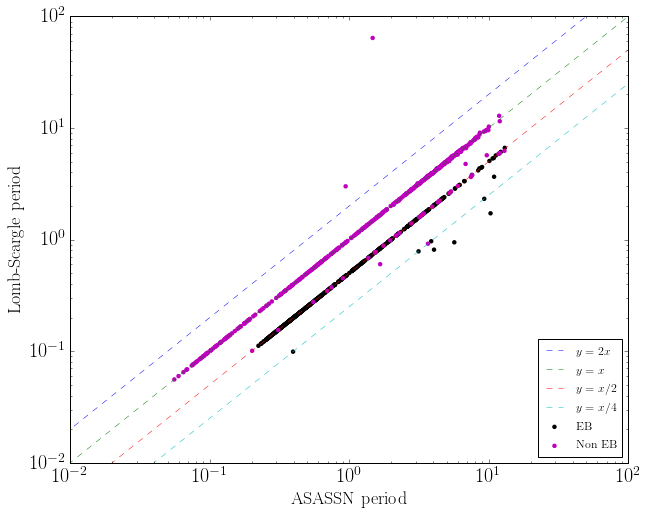

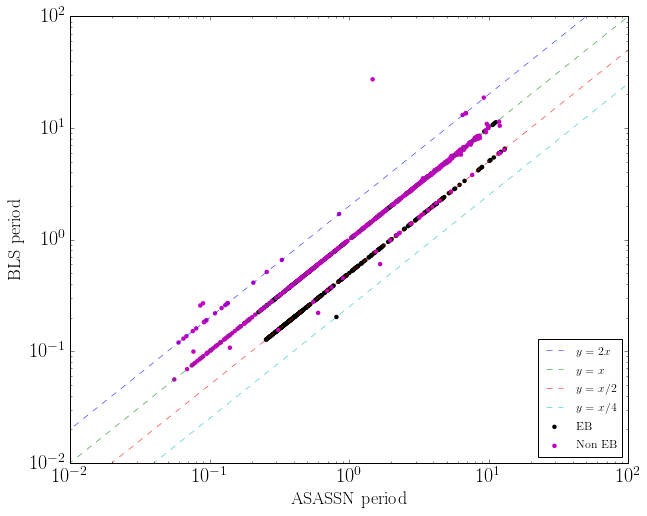

In [5]:
s1 = sample[sample['type'].isin(['EA', 'EB', 'EW'])]
s2 = sample[~sample['type'].isin(['EA', 'EB', 'EW'])]

x = np.arange(0,100)
plt.figure(figsize=[10,8])
plt.scatter(s1['period'], s1['ls_period'], edgecolor='none', facecolor='k', label='EB')
plt.scatter(s2['period'], s2['ls_period'], edgecolor='none', facecolor='m', label='Non EB')
plt.plot(x,2*x, linewidth=.5, linestyle='--', label=r'$y=2x$')
plt.plot(x,x, linewidth=.5, linestyle='--', label=r'$y=x$')
plt.plot(x,x/2, linewidth=.5, linestyle='--', label=r'$y=x/2$')
plt.plot(x,x/4, linewidth=.5, linestyle='--', label=r'$y=x/4$')
plt.legend(loc='lower right', scatterpoints=1)
plt.xlabel('ASASSN period', fontsize=18)
plt.ylabel('Lomb-Scargle period', fontsize=18)
plt.xscale('log')
plt.yscale('log')
plt.xlim(.01,100)
plt.ylim(.01,100)
# plt.savefig('period_comparison.png')
plt.show()

x = np.arange(0,100)
plt.figure(figsize=[10,8])
plt.scatter(s1['period'], s1['bls_period'], edgecolor='none', facecolor='k', label='EB')
plt.scatter(s2['period'], s2['bls_period'], edgecolor='none', facecolor='m', label='Non EB')
plt.plot(x,2*x, linewidth=.5, linestyle='--', label=r'$y=2x$')
plt.plot(x,x, linewidth=.5, linestyle='--', label=r'$y=x$')
plt.plot(x,x/2, linewidth=.5, linestyle='--', label=r'$y=x/2$')
plt.plot(x,x/4, linewidth=.5, linestyle='--', label=r'$y=x/4$')
plt.legend(loc='lower right', scatterpoints=1)
plt.xlabel('ASASSN period', fontsize=18)
plt.ylabel('BLS period', fontsize=18)
plt.xscale('log')
plt.yscale('log')
plt.xlim(.01,100)
plt.ylim(.01,100)
# plt.savefig('period_comparison.png')
plt.show()

In [65]:
bad = sample.query('ls_period < (period/2 - .1*period)')
print(len(bad))

# parr = np.linspace(0,1,100)
# for i, fl in enumerate(list(bad['flux'])):
#     print(list(bad['tic_id'])[i])
#     print('A per:', list(bad['period'])[i])
#     print('LS per:', list(bad['ls_period'])[i])
#     print(list(bad['ls_period'])[i]/list(bad['period'])[i])
#     plt.plot(parr, fl, label=list(bad['type'])[i])
#     plt.legend(loc='upper left')
#     plt.show()

11


In [84]:
ls_flux_fold = ps_dict['data'].fold(period=ps_dict['ls_best_period']*u.day)

In [ ]:
from scipy import optimize

def test_func(x, a, T, p, h):
    return a * np.sin(2*np.pi*x/T - p) + h

params, params_covariance = optimize.curve_fit(test_func, pharr, ls_flux_binned, p0=[2,.5,-.2,.1])

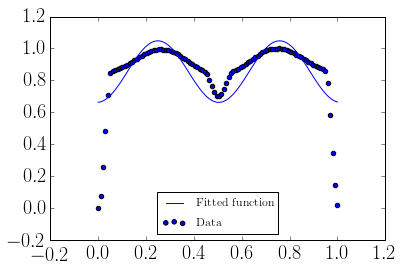

In [29]:
plt.figure(figsize=(6, 4))
plt.scatter(pharr, ls_flux_binned, label='Data')
plt.plot(pharr, test_func(pharr, params[0], params[1], params[2], params[3]),label='Fitted function')

plt.legend(loc='best')

plt.show()

EB
ASASSN: 12.220360099999999
LS: 6.108089489678122
BLS: 6.115732244294836


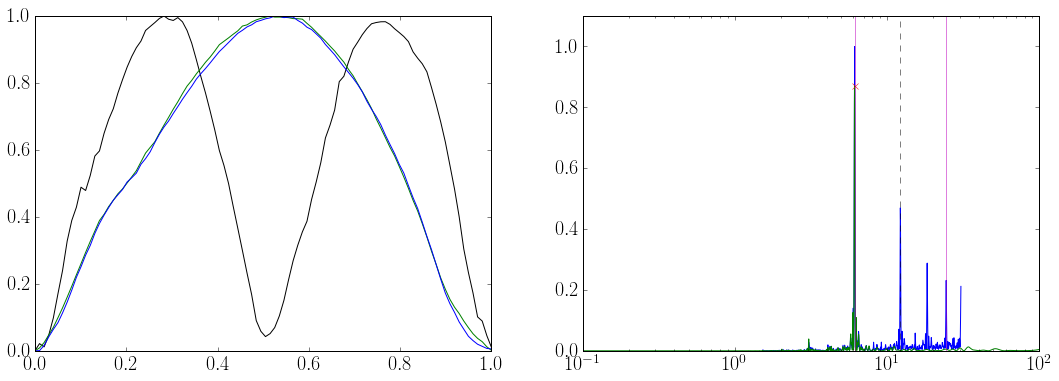

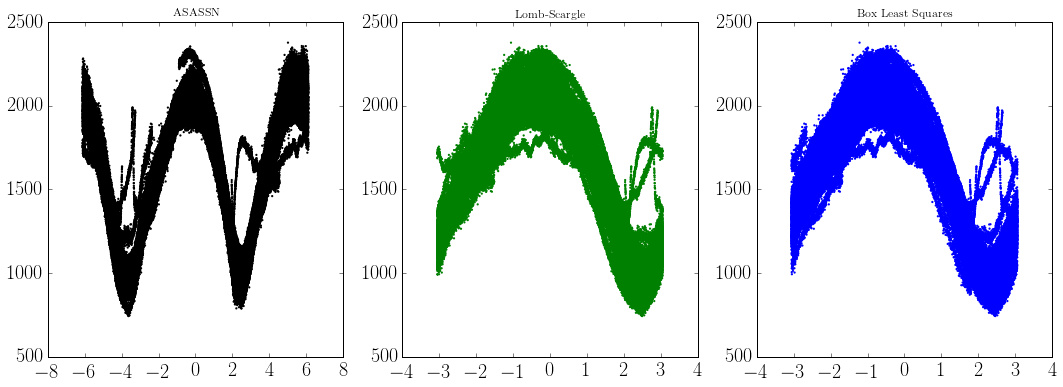

EB
ASASSN: 0.5968791
LS: 0.2984181275979179
BLS: 0.2987915236534709


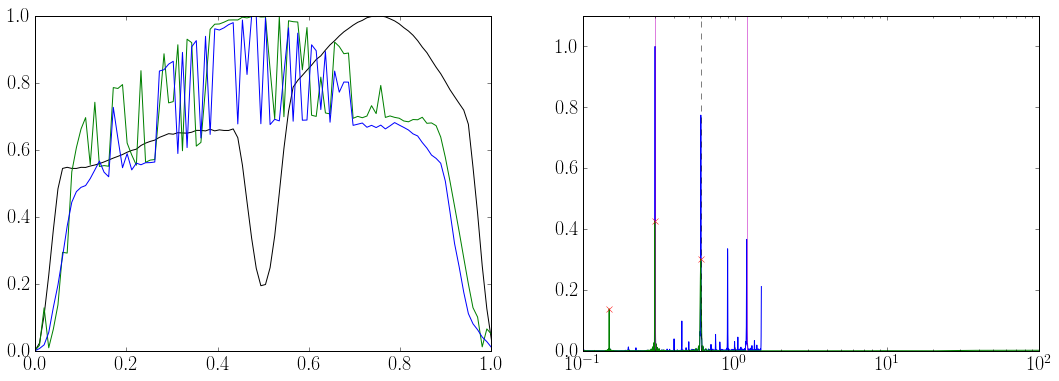

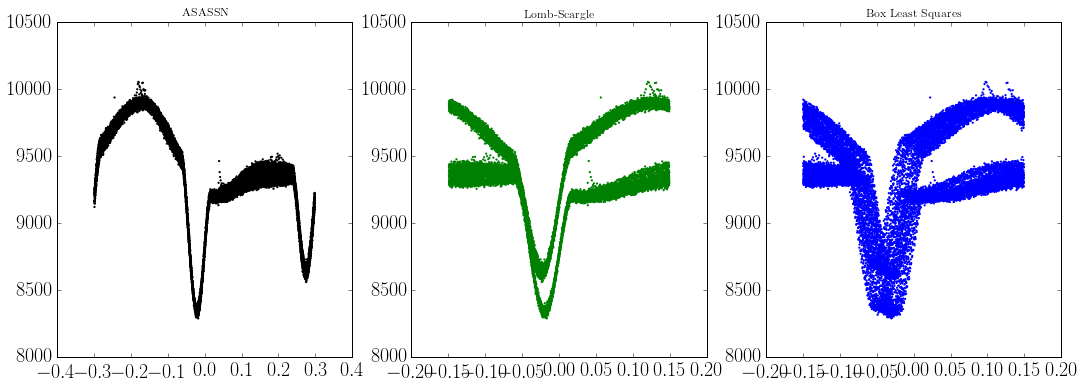

EB
ASASSN: 0.631471
LS: 0.3156463222942723
BLS: 0.31604127514999586


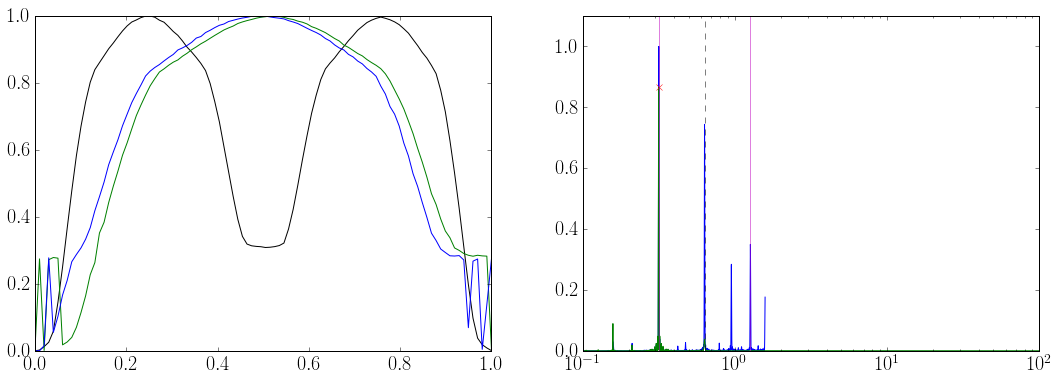

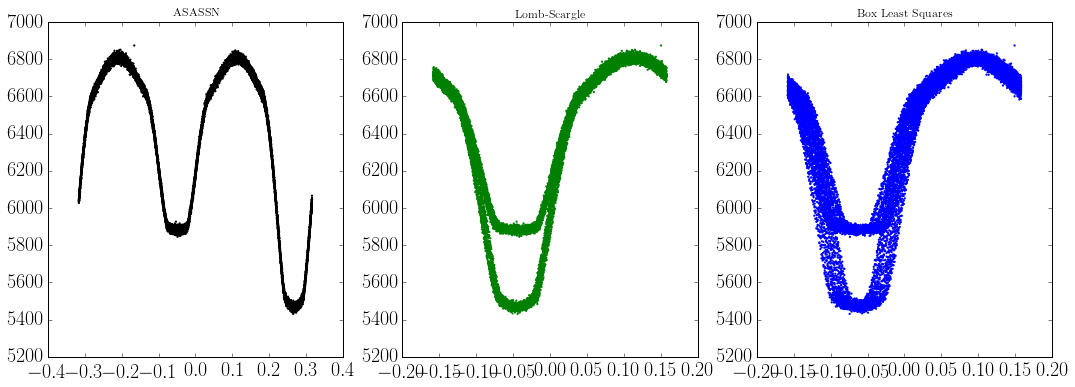

EB
ASASSN: 0.9536861999999999
LS: 0.47717634985019614
BLS: 0.4777734173550137


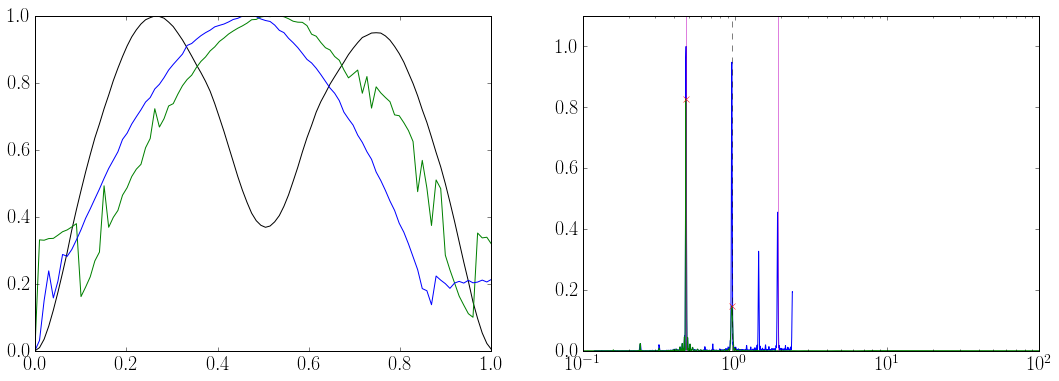

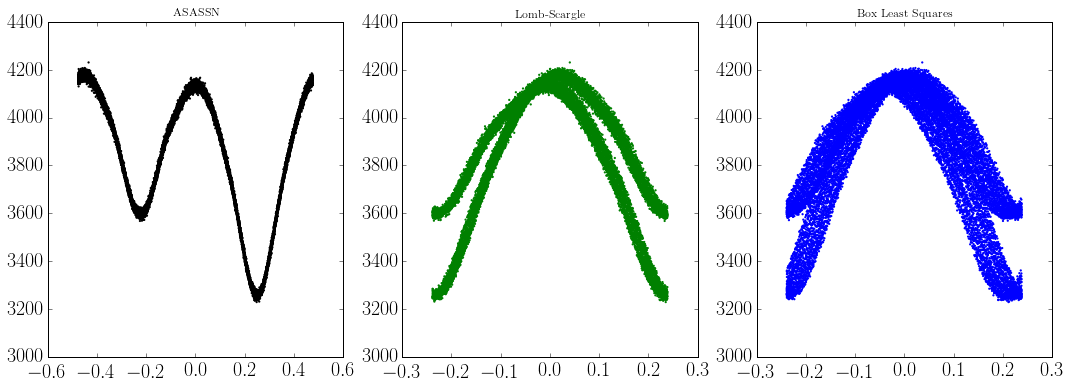

EB
ASASSN: 1.1625303999999999
LS: 0.5817124429257743
BLS: 0.5824403113478536


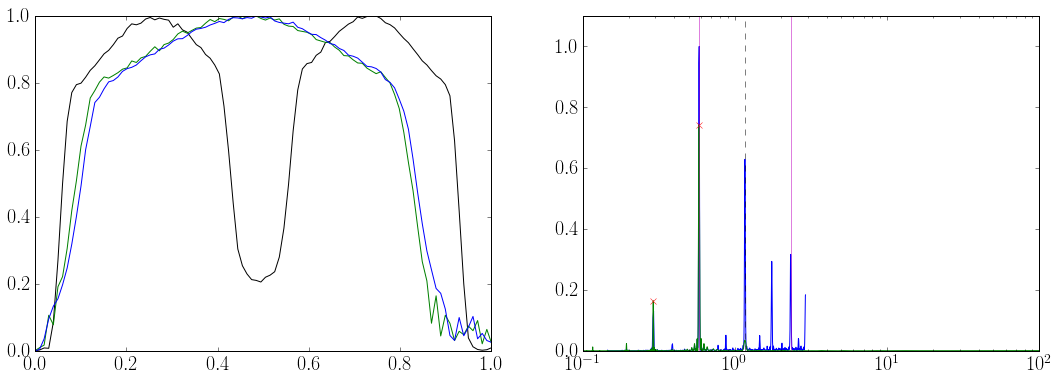

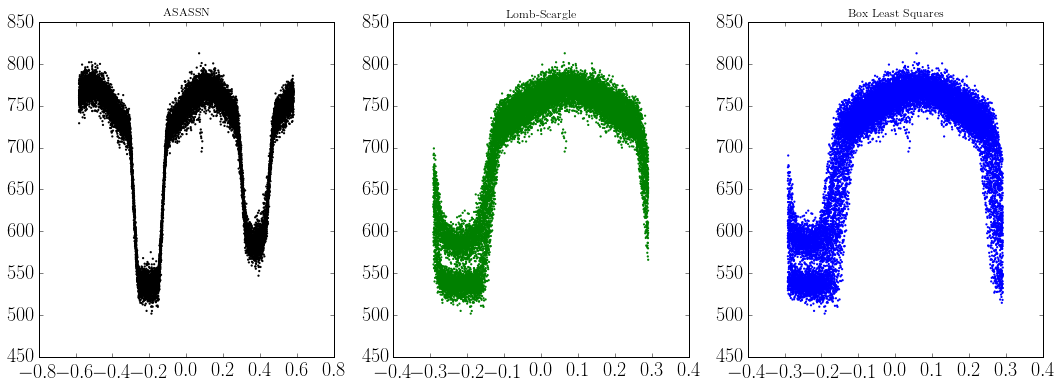

In [6]:
s = sample[sample['type'] == 'EB'].reset_index(drop=True)
pharr = np.linspace(0,1,100)
scaler = MinMaxScaler()

for i in np.arange(5,10):
    print(s['type'][i])
    infile = open(f"{tb.ps_dir}/{s['tic_id'][i]}_ps.pkl",'rb')
    ps_dict = pickle.load(infile)
    infile.close()

    peaks, properties = find_peaks(ps_dict['ls_pwr_spec'][1], height=.1, distance=100)
#     widths = peak_widths(ps_dict['ls_pwr_spec'][1], peaks, rel_height=0.5)[0]
#     ps_dict['ls_best_period'] *= 2
#     ps_dict['bls_best_period'] *= 2

    print('ASASSN:', s['period'][i])
    print('LS:', ps_dict['ls_best_period'])
    print('BLS:', ps_dict['bls_best_period'])
    
    #Fold data
    ls_flux_fold = ps_dict['data'].fold(period=ps_dict['ls_best_period']*u.day)
    ls_flux_binned = tb.binData(ls_flux_fold, 100)
    ls_flux_binned = np.roll(np.array(ls_flux_binned), 100-np.argmin(ls_flux_binned))
    ls_dat = np.vstack([pharr, ls_flux_binned]).T
    scaler.fit(ls_dat)
    ls_flux_binned = scaler.transform(ls_dat).T[1]
    
    bls_flux_fold = ps_dict['data'].fold(period=ps_dict['bls_best_period']*u.day)
    bls_flux_binned = tb.binData(bls_flux_fold, 100)
    bls_flux_binned = np.roll(np.array(bls_flux_binned), 100-np.argmin(bls_flux_binned))
    bls_dat = np.vstack([pharr, bls_flux_binned]).T
    scaler.fit(bls_dat)
    bls_flux_binned = scaler.transform(bls_dat).T[1]
    
    as_flux_fold = ps_dict['data'].fold(period=s['period'][i]*u.day)

    fig, (ax1,ax2) = plt.subplots(1,2, figsize=[18,6])
    
    ax1.plot(pharr, s['flux'][i], color='k')
    ax1.plot(pharr, ls_flux_binned, color='g')
    ax1.plot(pharr, bls_flux_binned, color='b')
    
    ax2.plot(ps_dict['bls_pwr_spec'][0], ps_dict['bls_pwr_spec'][1]/max(ps_dict['bls_pwr_spec'][1]), color='b')
    ax2.plot(ps_dict['ls_pwr_spec'][0], ps_dict['ls_pwr_spec'][1], color='g')
    ax2.plot(ps_dict['ls_pwr_spec'][0][peaks], ps_dict['ls_pwr_spec'][1][peaks], "x", color='r')
    ax2.axvline(s['period'][i], color='k', alpha=.5, linestyle='--')
#     ax2.axvline(ps_dict['ls_pwr_spec'][0][peaks[np.argmax(properties['peak_heights'])]], color='r', alpha=.5)
    ax2.axvline(2*s['period'][i], color='m', alpha=.5)
    ax2.axvline(.5*s['period'][i], color='m', alpha=.5)
#     ax2.axvline(.25*ps_dict['ls_pwr_spec'][0][peaks[np.argmax(properties['peak_heights'])]], color='m', alpha=.5)
    ax2.set_xscale('log')
    ax2.set_ylim(0,1.1)
    ax2.set_xlim(.1, 100)
    plt.show()
    
    fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=[18,6])
    ax1.scatter(as_flux_fold.time.jd, as_flux_fold['pdcsap_flux'], s=5, edgecolor='none', facecolor='k')
    ax2.scatter(ls_flux_fold.time.jd, ls_flux_fold['pdcsap_flux'], s=5, edgecolor='none', facecolor='g')
    ax3.scatter(bls_flux_fold.time.jd, bls_flux_fold['pdcsap_flux'], s=5, edgecolor='none', facecolor='b')
    ax1.set_title('ASASSN')
    ax2.set_title('Lomb-Scargle')
    ax3.set_title('Box Least Squares')
    plt.show()

In [5]:
alt.Chart(sample).mark_circle(size=60).encode(
    x='period',
    y='ls_period',
    color='type',
    tooltip=['tic_id', 'type']
).interactive()

<VegaLite 3 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/troubleshooting.html
